# CASE: Controle de Inadimplência em Operações de Crédito

# Resumo

# Introdução

Uma fintech de Crédito iniciou sua operação de concessão de empréstimo pessoal e acompanhou a performance de pagamento de 1.000 clientes após 1 ano. Com base dessa amostra, pediu para a área de Análise de Dados verificar quais os fatores de risco dos clientes de forma a conseguir aprovar mais contratos com a menor inadimplência possível.

Com base nessas informações, pede-se:

Quais fatores de risco estão mais associados a inadimplência? Com isso, o que a fintech deveria mudar de forma a minimizar a inadimplência?


# Importação das Bibliotecas

In [1]:
# Pacote de Manipulação de Dados
import pandas as pd
import numpy as np

# Pacote Gráfico
import seaborn as sns
import matplotlib.pyplot as plt

# Pacotes de Modelagem
import statsmodels as sms
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay
)

# Pacote de Funções Auxiliares
import utils.aux_func as af
from utils.paths import DATA_RAW

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Params
plt.rcParams['figure.dpi'] = 400
pd.set_option('display.max_columns', None)


# Importação da Base

In [2]:
df = pd.read_excel(DATA_RAW / "Base_Inadimplencia.xlsx", sheet_name="Base")
df.head(10)

Idade Sexo   Escolaridade Tipo_Moradia Saldo_Investimento  \
0     67    M      Graduacao      Propria   Sem investimento   
1     22    H      Graduacao      Propria              Pouco   
2     49    M  Pos Graduacao      Propria              Pouco   
3     45    M      Graduacao     De favor              Pouco   
4     53    M      Graduacao     De favor              Pouco   
5     35    M  Pos Graduacao     De favor   Sem investimento   
6     53    M      Graduacao      Propria               Alto   
7     35    M   Ensino Medio      Alugada              Pouco   
8     61    M  Pos Graduacao      Propria               Alto   
9     28    M   Ensino Medio      Propria              Pouco   

  Saldo_Conta_Corrente  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia  
0                Pouco              1169                   6              0  
1             Moderado              5951                  48              1  
2            Sem conta              2096                  12              0  
3                Pouco              7882                  42              0  
4                Pouco              4870                  24              1  
5            Sem conta              9055                  36              0  
6            Sem conta              2835                  24              0  
7             Moderado              6948                  36              0  
8            Sem conta              3059                  12              0  
9             Moderado              5234                  30              1

In [3]:
df.shape

(1000, 9)

# Dicionário de Dados (Metadados)


| Variável               | Tipo               | Faixa / Categorias                                                                 | Descrição                                                                 |
|------------------------|--------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Idade**              | Numérica (inteiro) | Geralmente entre 18 e 80 anos (dependendo do dataset)                                | Idade do cliente no momento da solicitação do empréstimo.                 |
| **Sexo**               | Categórica         | H (Homem), M (Mulher)                                                                | Sexo informado pelo cliente.                                              |
| **Escolaridade**       | Categórica ordinal | Médio, Graduação, Pós-Graduação                                                      | Nível educacional do cliente.                                             |
| **Tipo_Moradia**       | Categórica         | Mora de favor, Aluguel, Casa própria                                                 | Situação habitacional do cliente.                                         |
| **Saldo_Investimento** | Categórica ordinal | Faixas de saldo (ex.: Sem saldo, Baixo, Médio, Alto)                                 | Indica se o cliente possui investimentos em outro banco e a faixa de saldo. |
| **Saldo_Conta_Corrente** | Categórica ordinal | Faixas de saldo (ex.: Sem saldo, Baixo, Médio, Alto)                                 | Indica se possui conta corrente em outro banco e sua faixa de saldo.       |
| **Valor_Emprestimo**   | Numérica (contínua) | Valores monetários (ex.: RS 500 a RS 50.000, conforme dataset)                        | Valor solicitado no empréstimo pessoal.                                   |
| **Duracao_Emprestimo** | Numérica (inteiro) | Em meses (ex.: 6 a 60 meses)                                                          | Prazo do empréstimo em meses.                                             |
| **Inadimplencia**      | Binária            | 0 = Não inadimplente, 1 = Inadimplente                                               | Variável alvo que indica ocorrência de inadimplência após o empréstimo.   |


# 1. Sanity Check

## 1.1 Valores Faltantes (Missing Values)

In [4]:
df.isnull().sum()

Idade                   0
Sexo                    0
Escolaridade            0
Tipo_Moradia            0
Saldo_Investimento      0
Saldo_Conta_Corrente    0
Valor_Emprestimo        0
Duracao_Emprestimo      0
Inadimplencia           0
dtype: int64

## 1.2 Valores Inconsistentes

In [5]:
df.describe()

Idade  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia
count  1000.000000       1000.000000         1000.000000    1000.000000
mean     35.546000       3271.258000           20.903000       0.300000
std      11.375469       2822.736876           12.058814       0.458487
min      19.000000        250.000000            4.000000       0.000000
25%      27.000000       1365.500000           12.000000       0.000000
50%      33.000000       2319.500000           18.000000       0.000000
75%      42.000000       3972.250000           24.000000       1.000000
max      75.000000      18424.000000           72.000000       1.000000

In [6]:
# Itera por todas as colunas categóricas (tipo object ou category)
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColuna: {col}")
    print(df[col].unique())


Coluna: Sexo
<StringArray>
['M', 'H']
Length: 2, dtype: str

Coluna: Escolaridade
<StringArray>
['Graduacao', 'Pos Graduacao', 'Ensino Medio']
Length: 3, dtype: str

Coluna: Tipo_Moradia
<StringArray>
['Propria', 'De favor', 'Alugada']
Length: 3, dtype: str

Coluna: Saldo_Investimento
<StringArray>
['Sem investimento', 'Pouco', 'Alto', 'Moderado']
Length: 4, dtype: str

Coluna: Saldo_Conta_Corrente
<StringArray>
['Pouco', 'Moderado', 'Sem conta', 'Alto']
Length: 4, dtype: str


In [7]:
df.nunique()

Idade                    53
Sexo                      2
Escolaridade              3
Tipo_Moradia              3
Saldo_Investimento        4
Saldo_Conta_Corrente      4
Valor_Emprestimo        921
Duracao_Emprestimo       33
Inadimplencia             2
dtype: int64

## 1.3 Valores Duplicados

In [8]:
df.duplicated().sum()

np.int64(0)

## 1.4 Tipagem de Dados

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Idade                 1000 non-null   int64
 1   Sexo                  1000 non-null   str  
 2   Escolaridade          1000 non-null   str  
 3   Tipo_Moradia          1000 non-null   str  
 4   Saldo_Investimento    1000 non-null   str  
 5   Saldo_Conta_Corrente  1000 non-null   str  
 6   Valor_Emprestimo      1000 non-null   int64
 7   Duracao_Emprestimo    1000 non-null   int64
 8   Inadimplencia         1000 non-null   int64
dtypes: int64(4), str(5)
memory usage: 70.4 KB


In [10]:
target = 'Inadimplencia'
num_vars = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != target]
cat_vars = [col for col in df.columns if (df[col].dtype == 'object' or str(df[col].dtype) == 'category' or df[col].dtype == 'str') and col != target]

In [11]:
num_vars

['Idade', 'Valor_Emprestimo', 'Duracao_Emprestimo']

In [12]:
cat_vars

['Sexo',
 'Escolaridade',
 'Tipo_Moradia',
 'Saldo_Investimento',
 'Saldo_Conta_Corrente']

## 1.5 Análise de Outliers

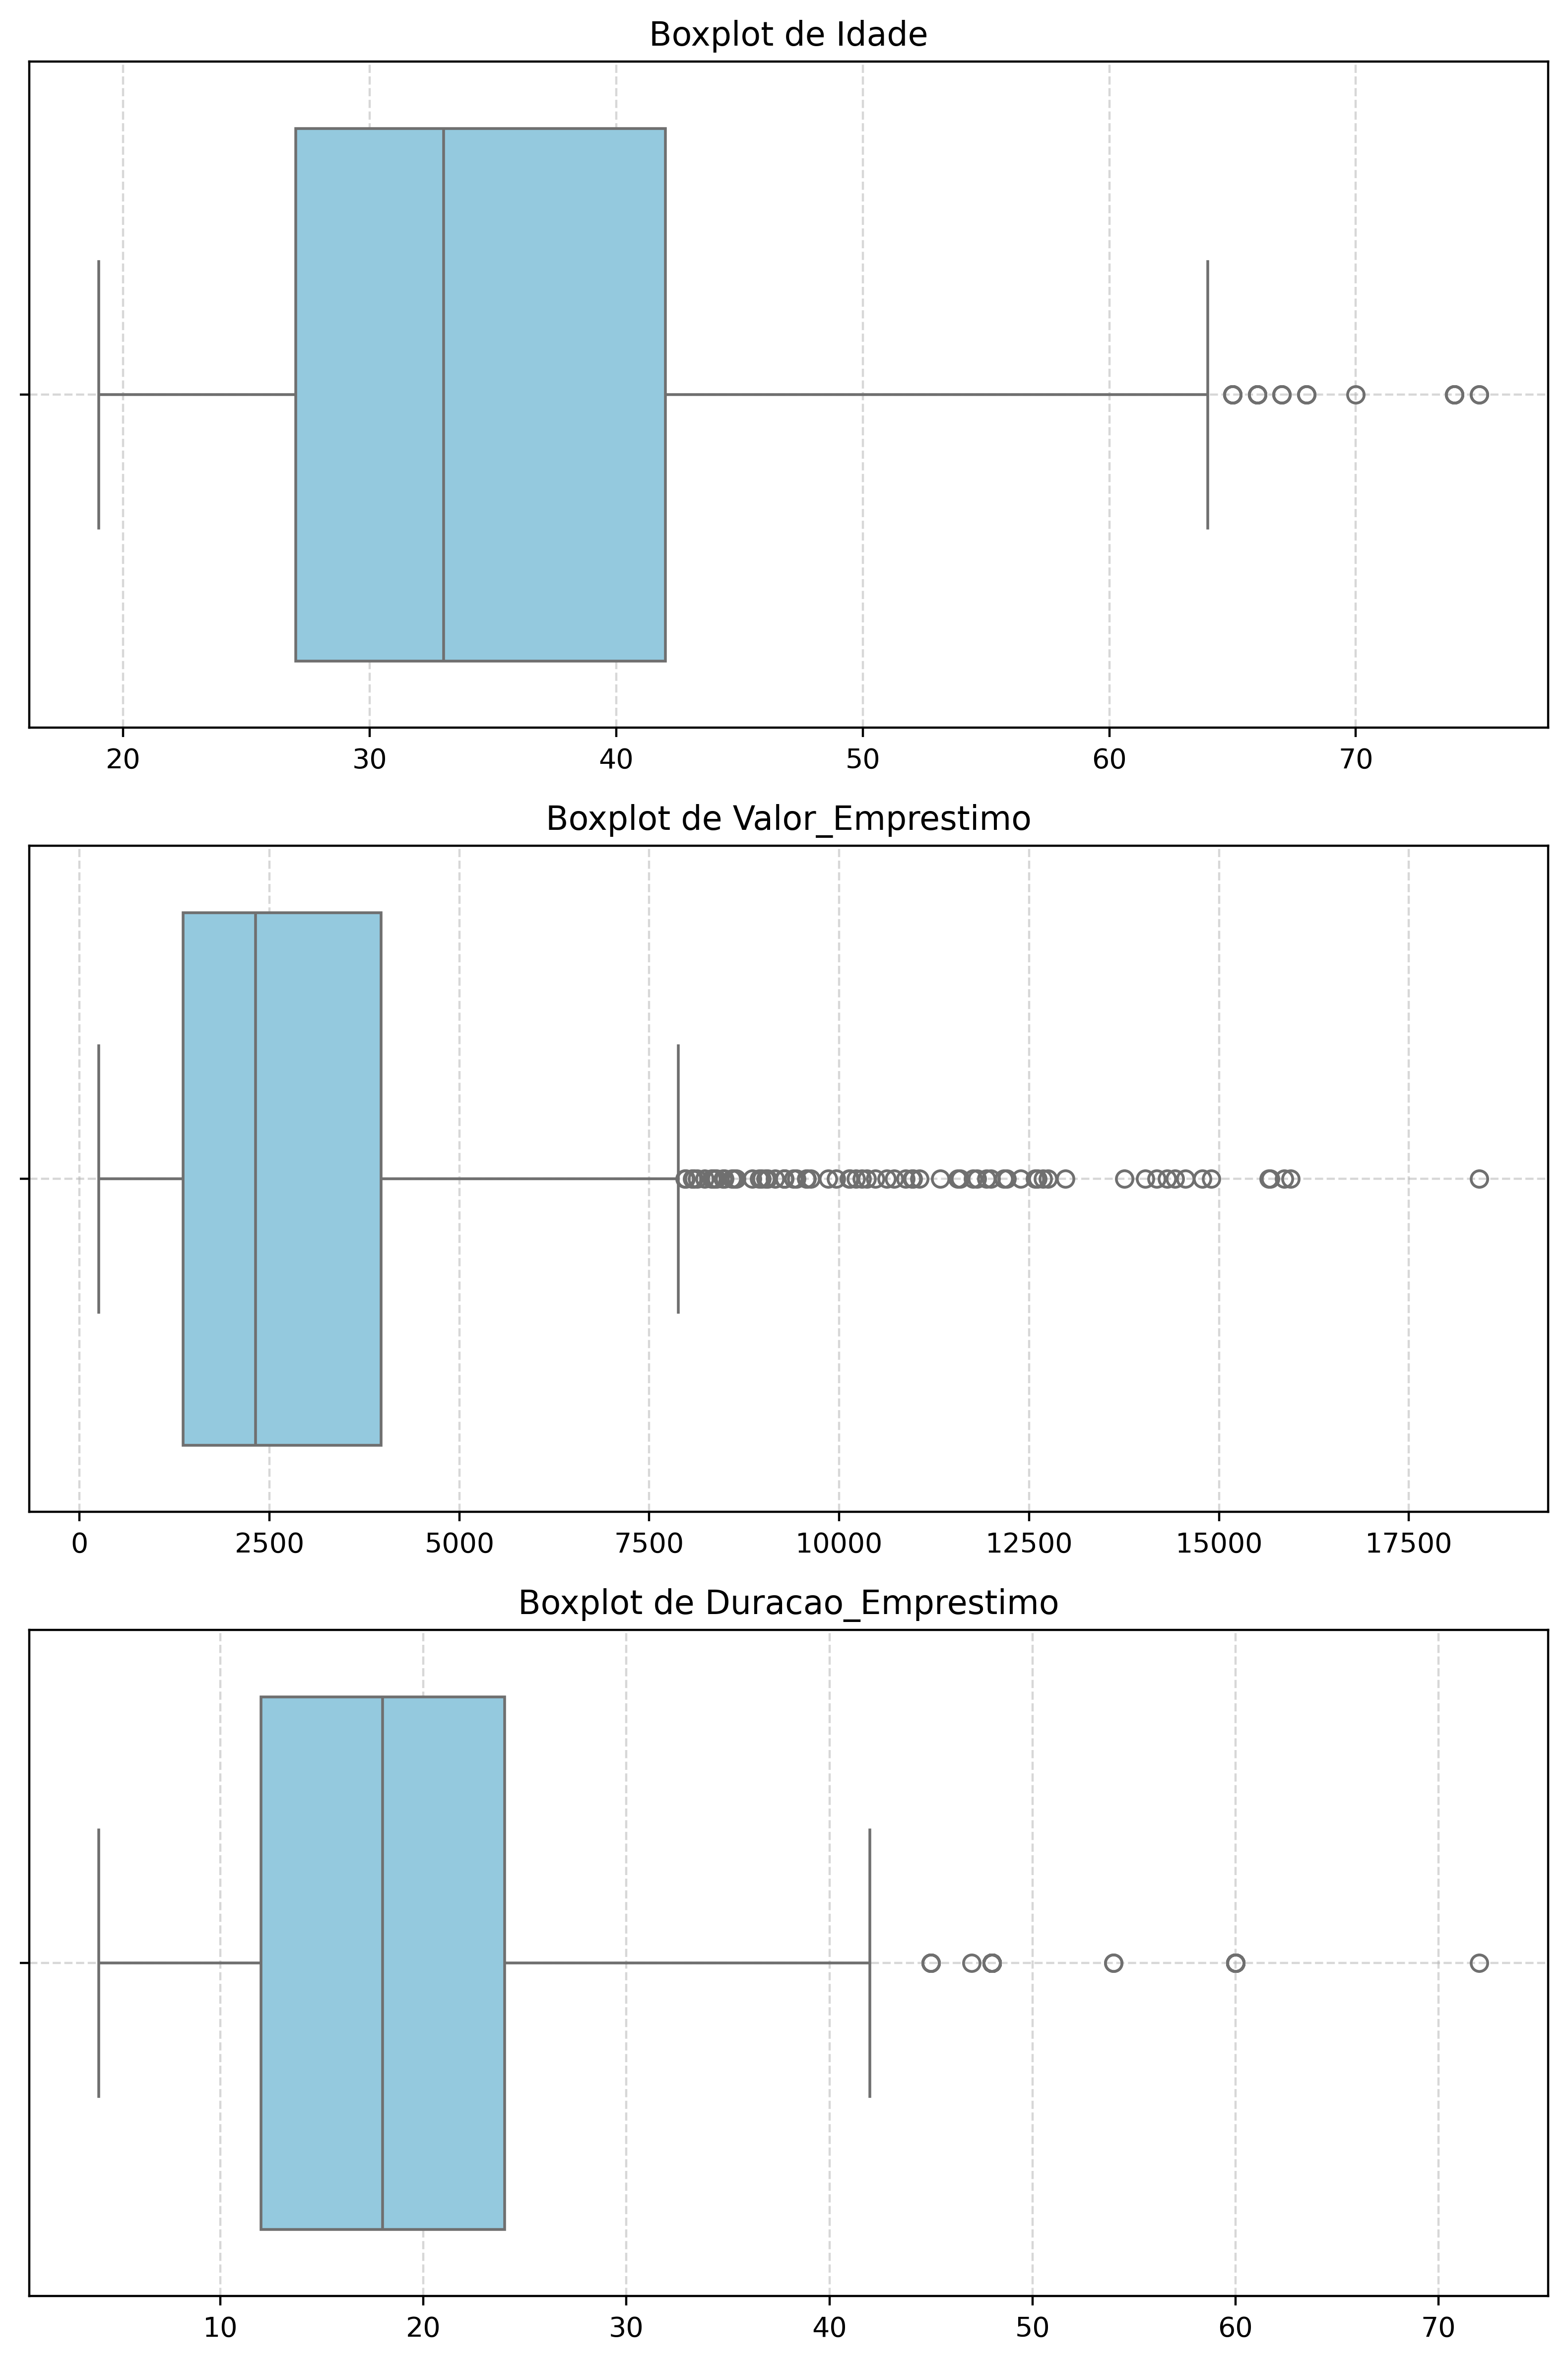

In [13]:
# Boxplots das variáveis quantitativas
## Cria o número de subplots com base na quantidade de variáveis numéricas
fig, axes = plt.subplots(nrows=len(num_vars), ncols=1, figsize=(8, 4 * len(num_vars)))

## Caso haja apenas uma variável, 'axes' não é uma lista — ajustamos isso
if len(num_vars) == 1:
    axes = [axes]

## Itera sobre as variáveis numéricas e plota cada boxplot em seu respectivo eixo
for i, col in enumerate(num_vars):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [14]:
# percentual de Outliers
outlier_stats = af.perc_outliers(df, num_vars)
display(outlier_stats)

Variável  %_Outliers
0    Valor_Emprestimo         7.2
1  Duracao_Emprestimo         7.0
2               Idade         2.3

# 2. Análise Exploratória dos Dados (AED)

## 2.1 Análise Univariada

### 2.1.1 Medidas Resumo - Análise Descritiva

In [15]:
df.describe()

Idade  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia
count  1000.000000       1000.000000         1000.000000    1000.000000
mean     35.546000       3271.258000           20.903000       0.300000
std      11.375469       2822.736876           12.058814       0.458487
min      19.000000        250.000000            4.000000       0.000000
25%      27.000000       1365.500000           12.000000       0.000000
50%      33.000000       2319.500000           18.000000       0.000000
75%      42.000000       3972.250000           24.000000       1.000000
max      75.000000      18424.000000           72.000000       1.000000

### 2.1.2 Análise de Normalidade - Histogramas + QQPlots + Testes Shapiro-Wilk (num_vars)

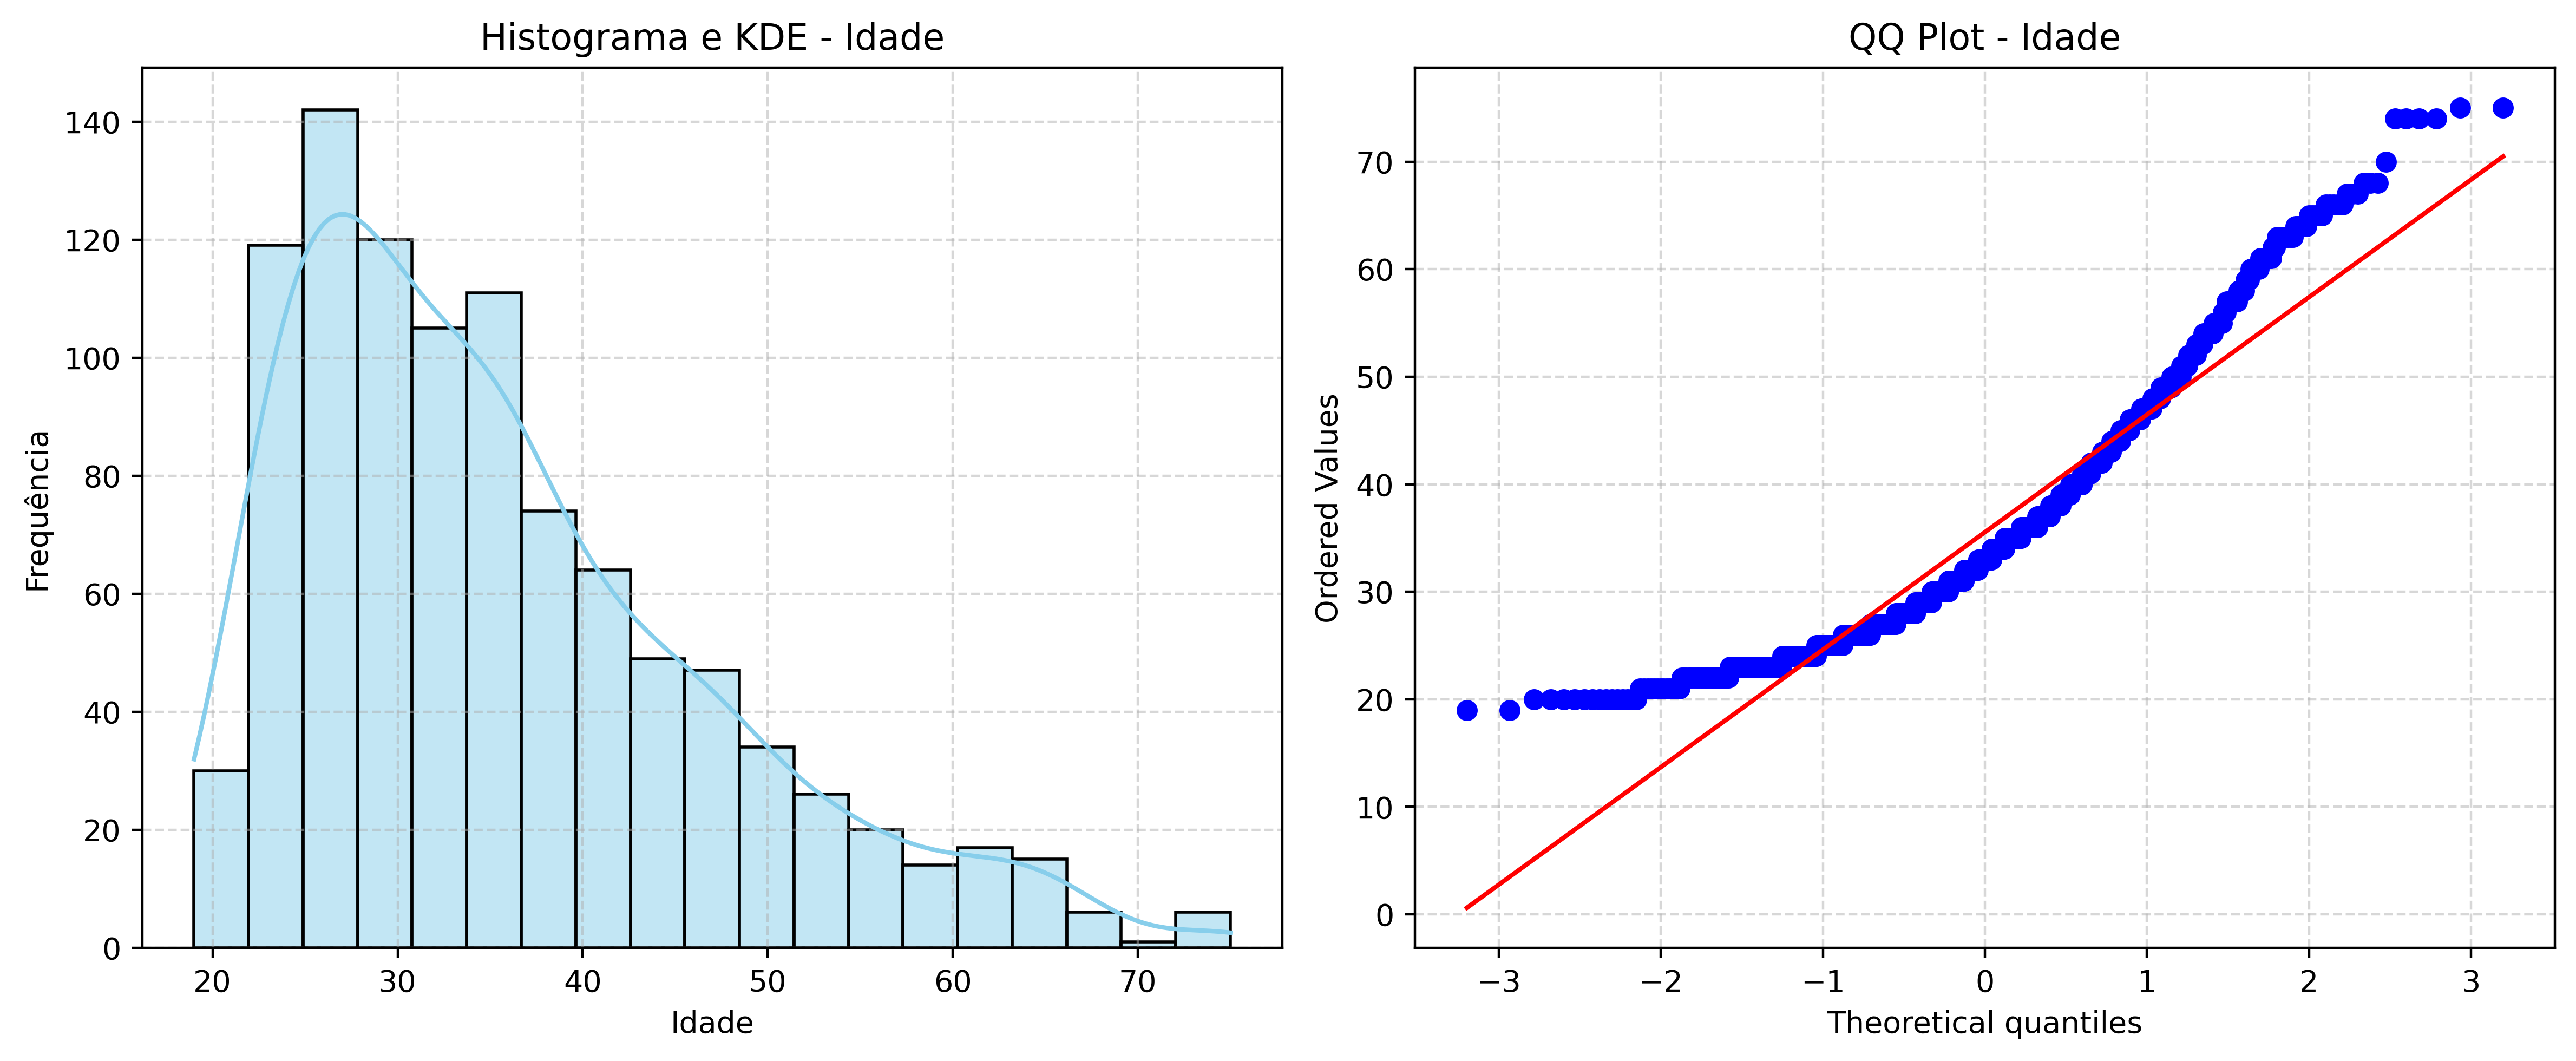

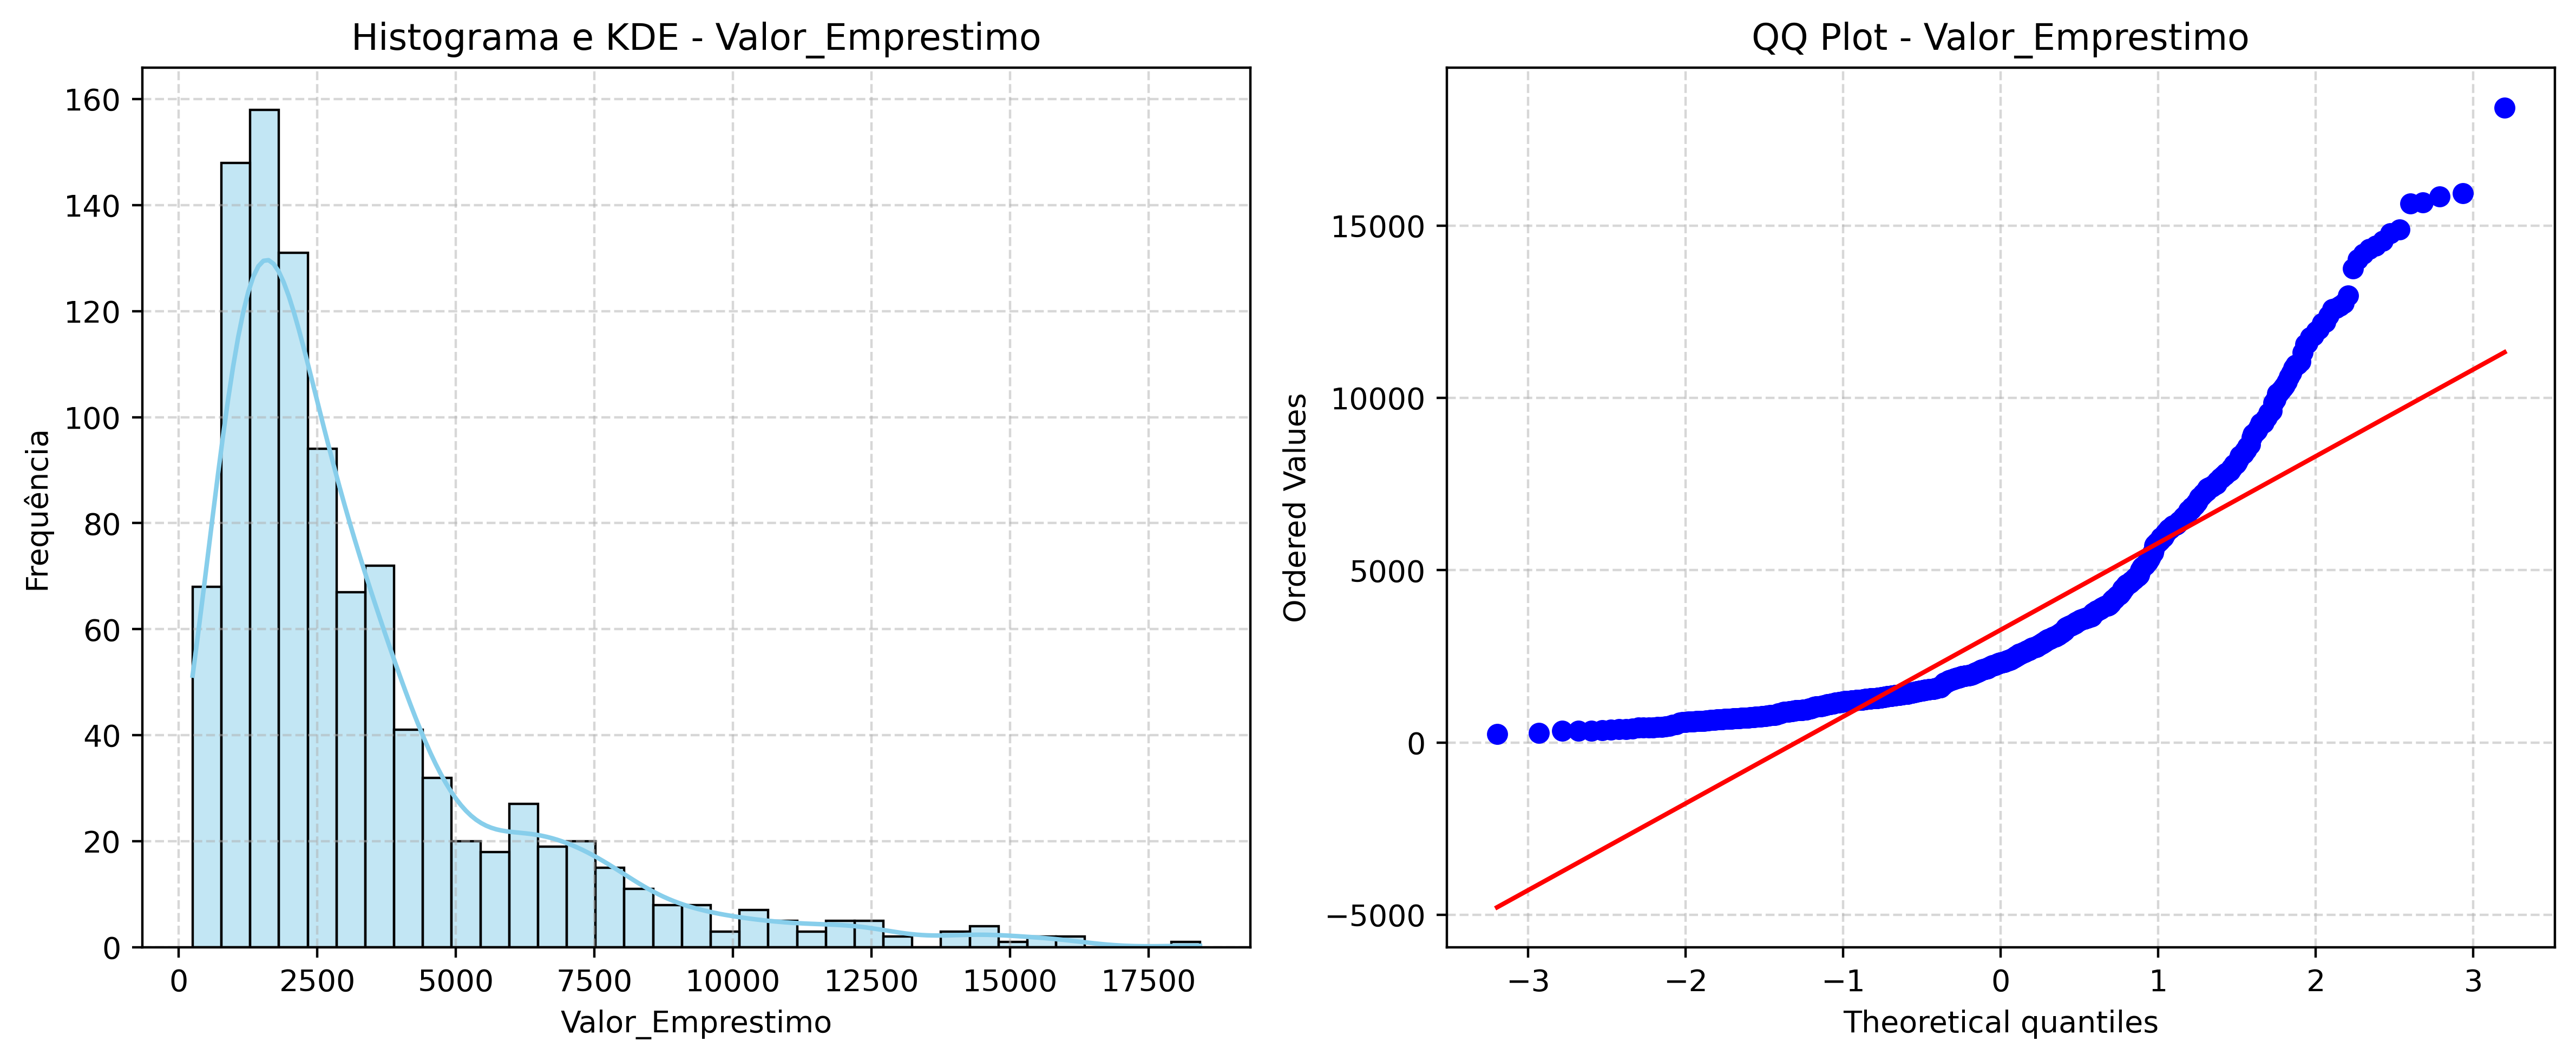

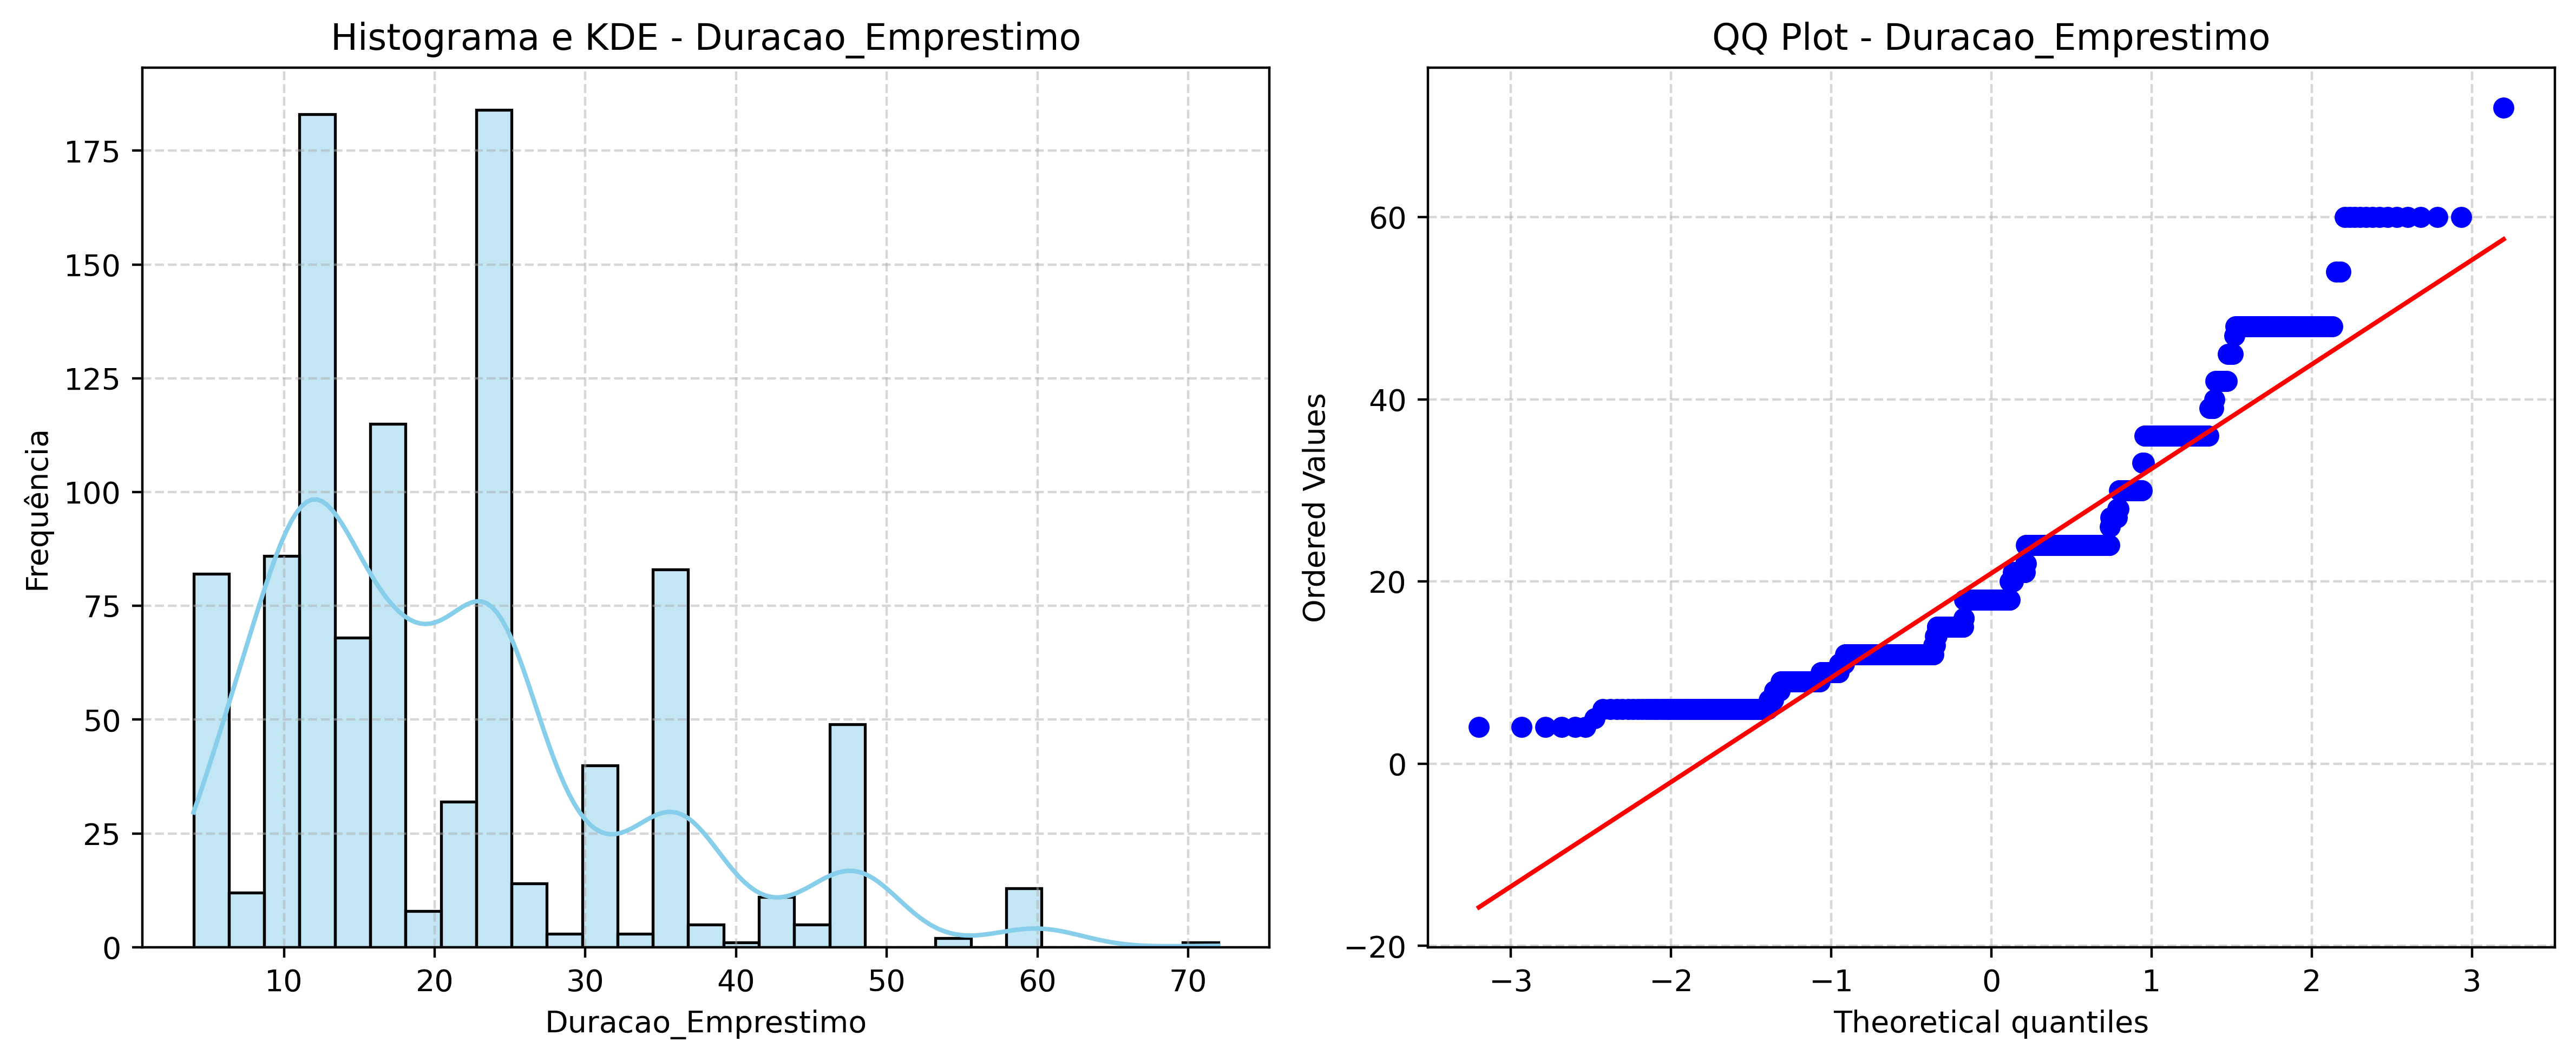

In [16]:
# subplots num_vars
for col in num_vars:
    af.plot_univariate(df, col)

In [17]:
shapiro_results = af.test_normality_shapiro(df, num_vars)
shapiro_results

Variável         W       p-valor                  Interpretação
0               Idade  0.917471  6.382098e-23  Não segue distribuição normal
1    Valor_Emprestimo  0.793396  8.608546e-34  Não segue distribuição normal
2  Duracao_Emprestimo  0.899788  4.906433e-25  Não segue distribuição normal

### 2.1.3 Tabelas de Frequência + Análises Visuais (cat_vars)

In [18]:
# Tabelas de Frequencia
for col in cat_vars:
    print('====='*20)
    display(af.freq_table(df, col))

Sexo  Frequência Absoluta  Frequência Relativa (%)  Frequência Acumulada (%)
0    M                  690                     69.0                      69.0
1    H                  310                     31.0                     100.0

Escolaridade  Frequência Absoluta  Frequência Relativa (%)  \
0      Graduacao                  630                     63.0   
1  Pos Graduacao                  200                     20.0   
2   Ensino Medio                  170                     17.0   

   Frequência Acumulada (%)  
0                      63.0  
1                      83.0  
2                     100.0

Tipo_Moradia  Frequência Absoluta  Frequência Relativa (%)  \
0      Propria                  713                     71.3   
1      Alugada                  179                     17.9   
2     De favor                  108                     10.8   

   Frequência Acumulada (%)  
0                      71.3  
1                      89.2  
2                     100.0

Saldo_Investimento  Frequência Absoluta  Frequência Relativa (%)  \
0              Pouco                  603                     60.3   
1   Sem investimento                  183                     18.3   
2               Alto                  111                     11.1   
3           Moderado                  103                     10.3   

   Frequência Acumulada (%)  
0                      60.3  
1                      78.6  
2                      89.7  
3                     100.0

Saldo_Conta_Corrente  Frequência Absoluta  Frequência Relativa (%)  \
0            Sem conta                  394                     39.4   
1                Pouco                  274                     27.4   
2             Moderado                  224                     22.4   
3                 Alto                  108                     10.8   

   Frequência Acumulada (%)  
0                      39.4  
1                      66.8  
2                      89.2  
3                     100.0

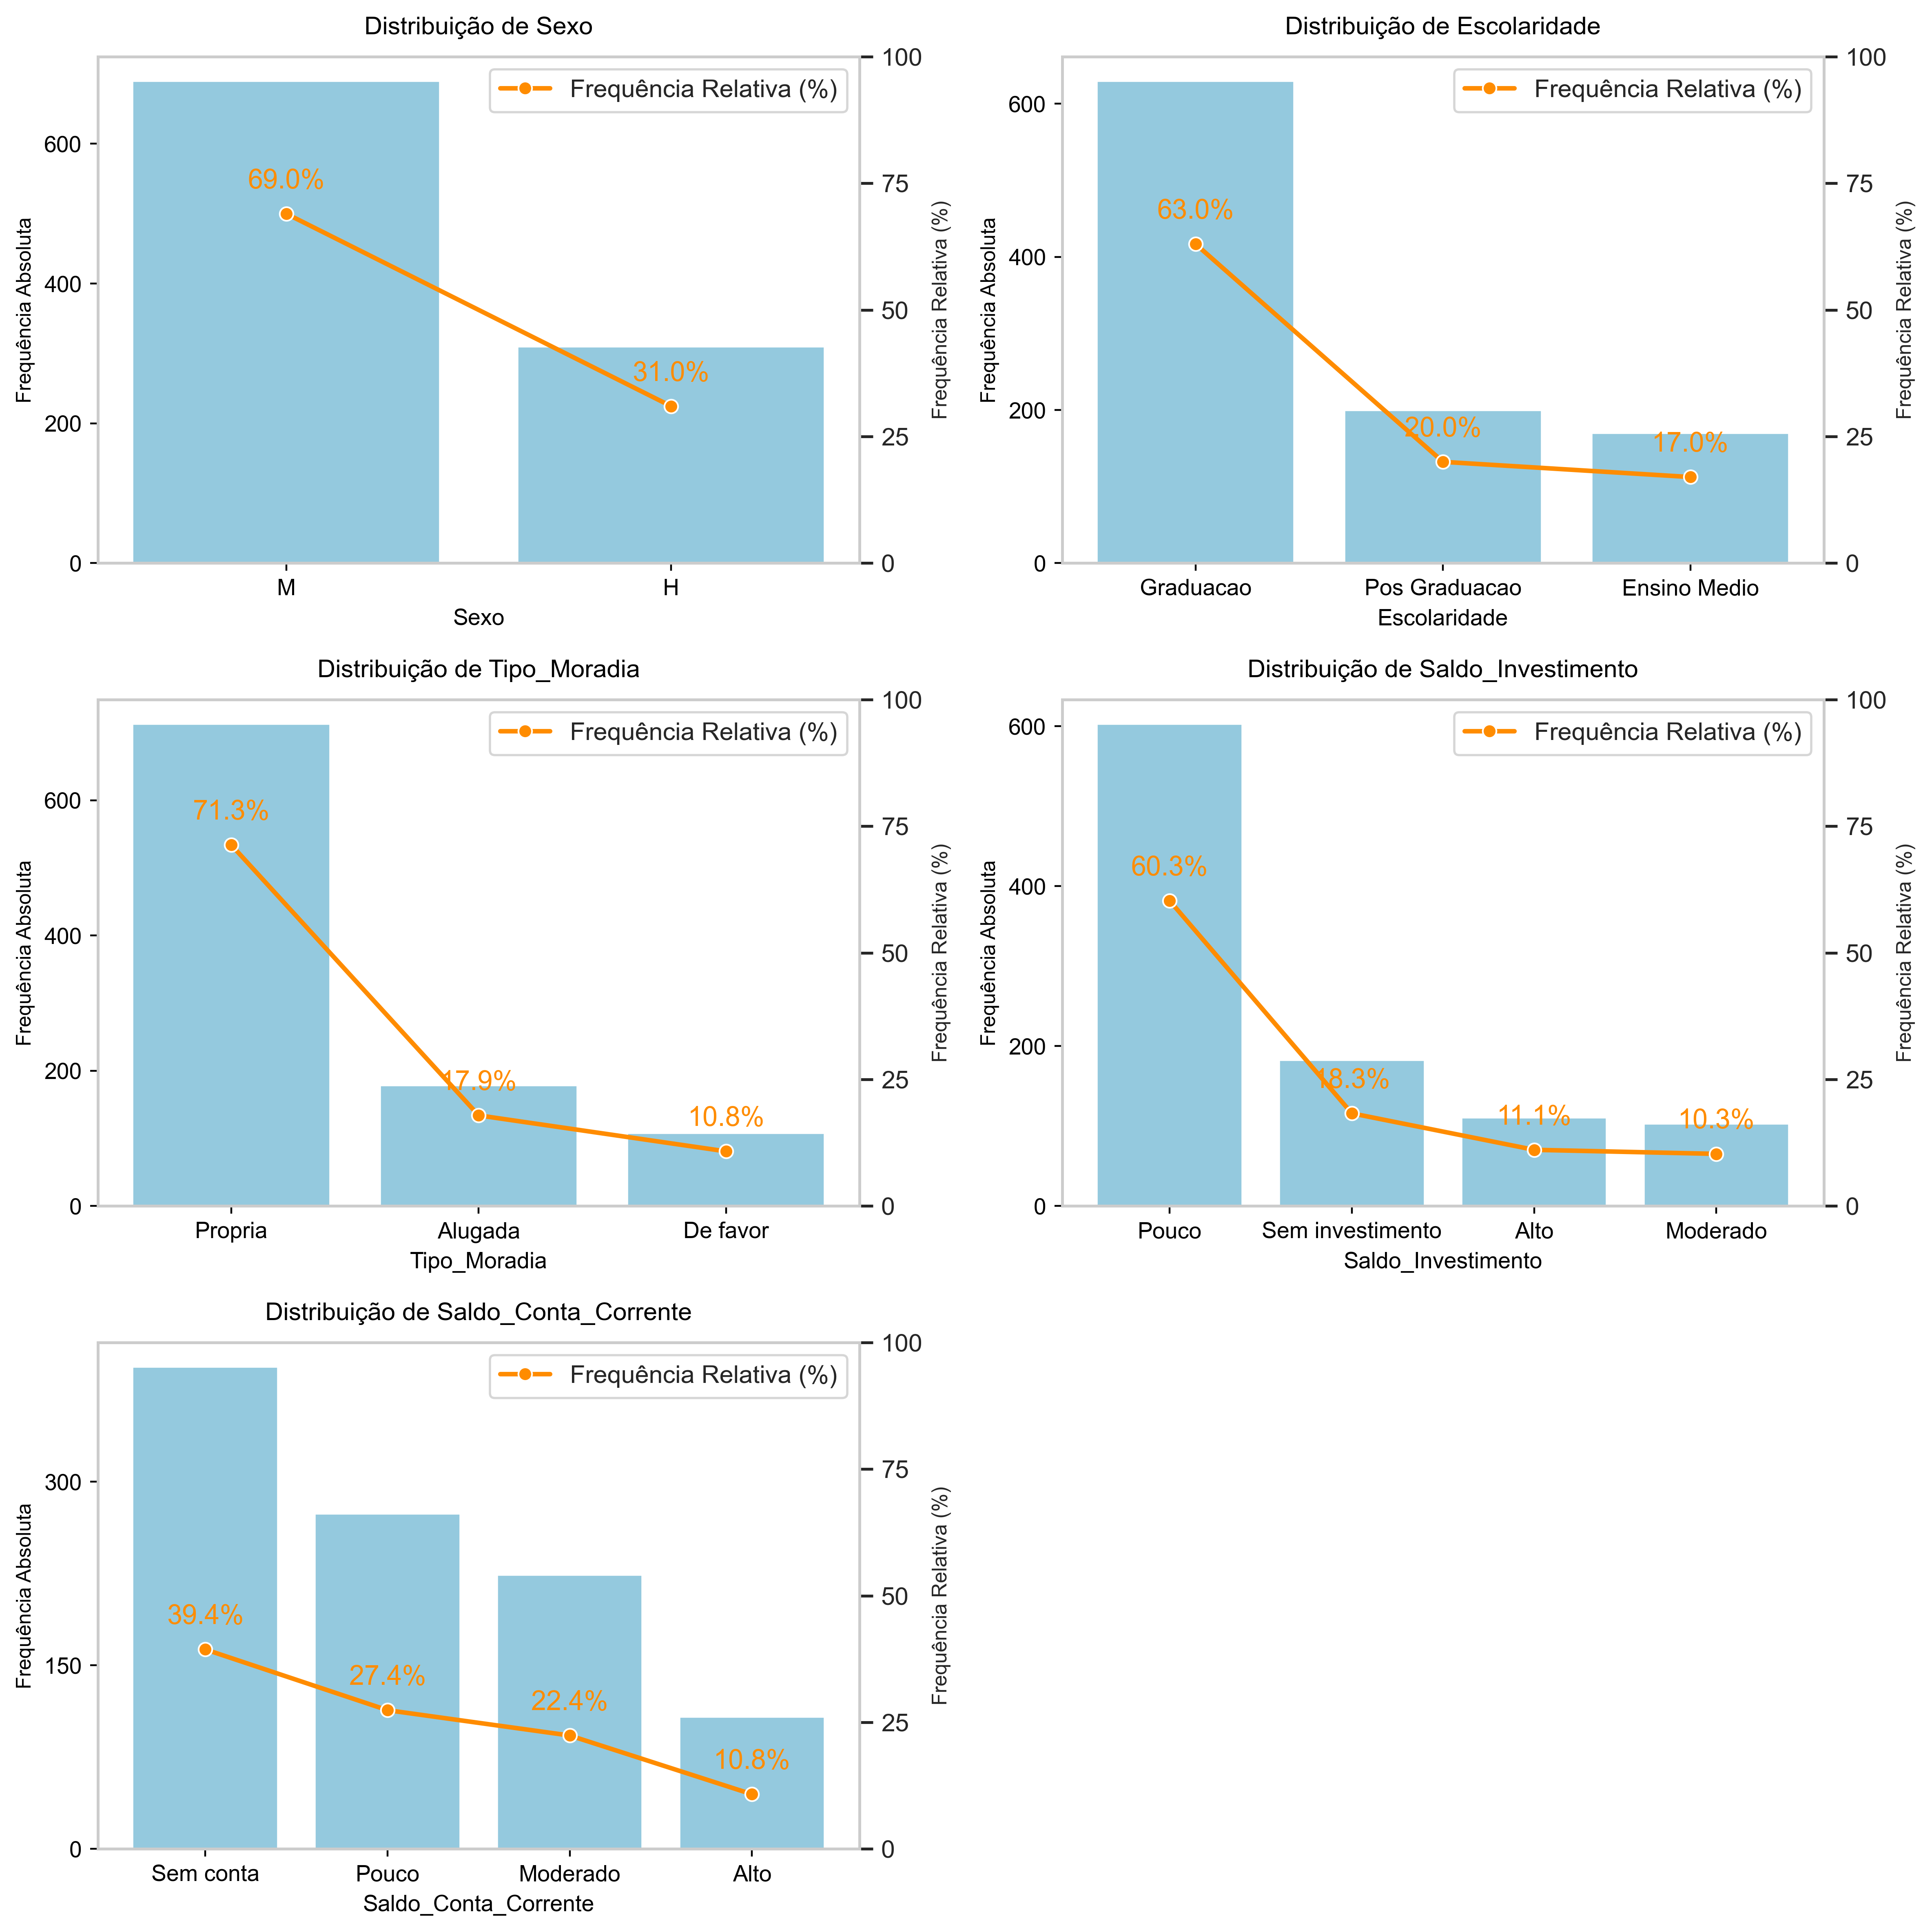

In [19]:
af.grid_freq_bars(df, cat_vars)

### 2.1.4 Balanceamento da Taxa de INADIMPLENCIA (DEFAULT)

In [20]:
df[target].value_counts(normalize=True).mul(100)

Inadimplencia
0    70.0
1    30.0
Name: proportion, dtype: float64

## 2.2 Análise Bivariada

### 2.2.1 Análise de Correlação/Associação

#### 2.2.1.1 PairPlot (num_vars)

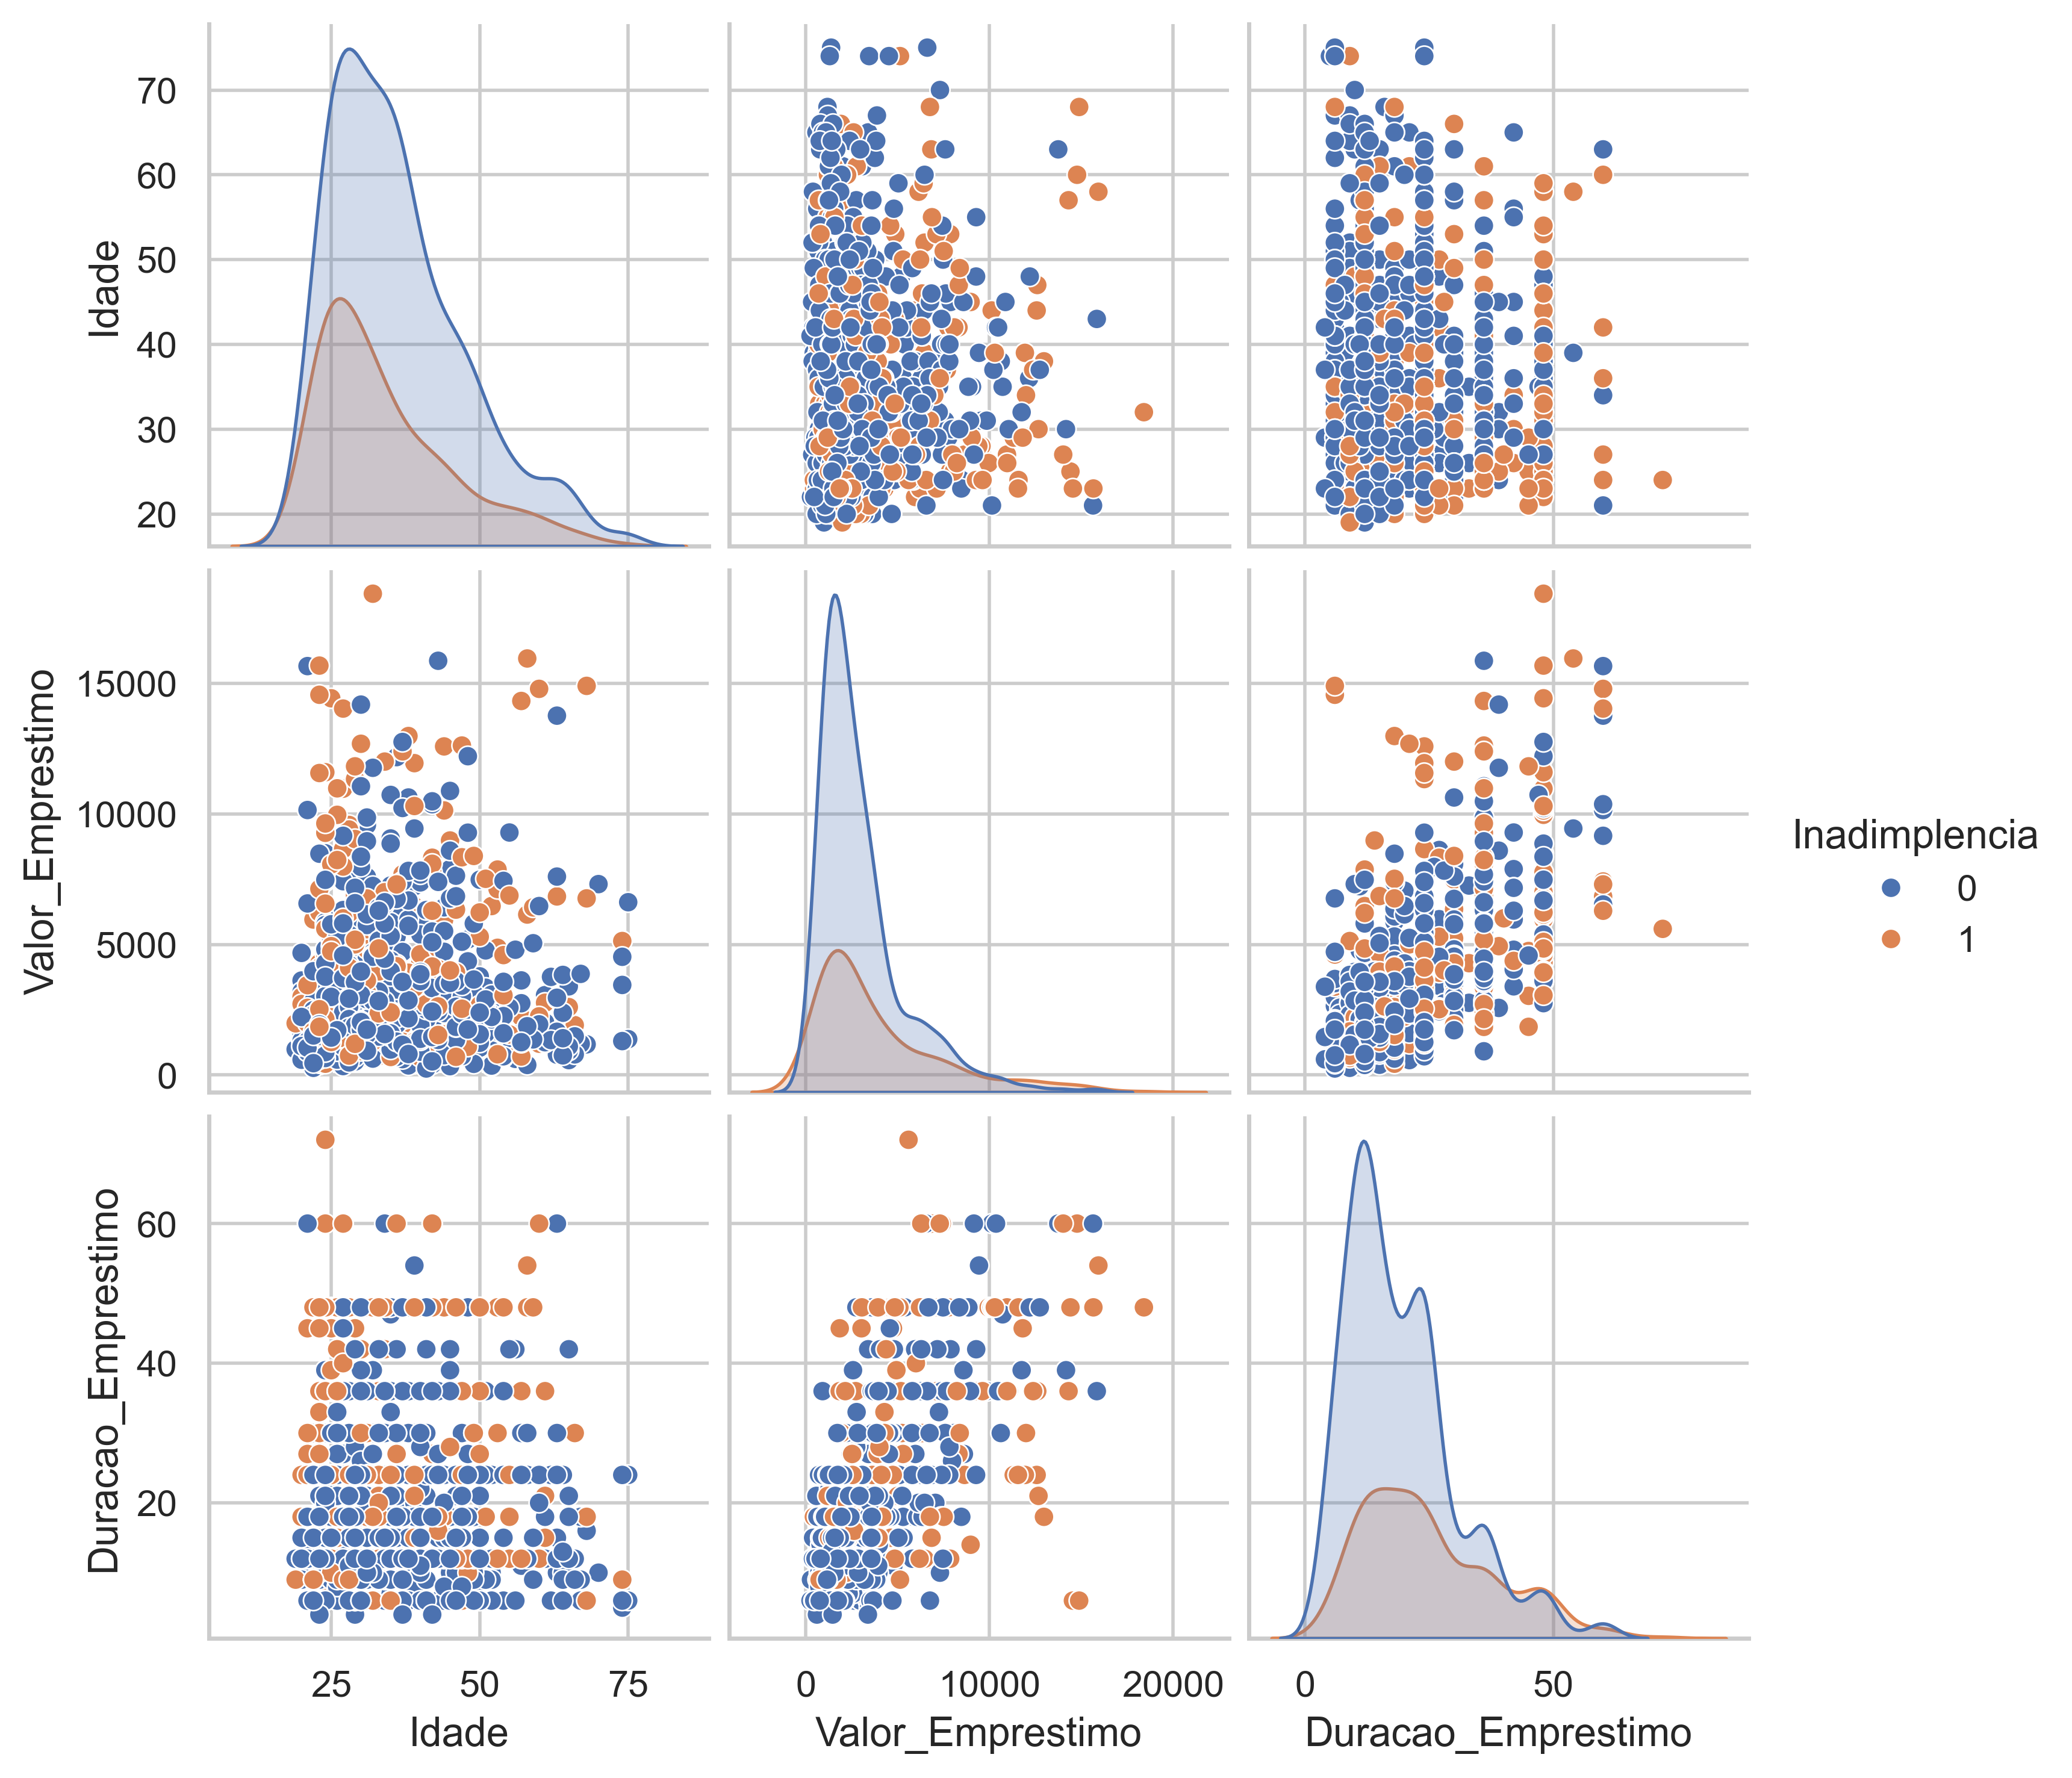

In [21]:
sns.pairplot(df, hue=target)

#### 2.2.1.2 Matriz de Correlação

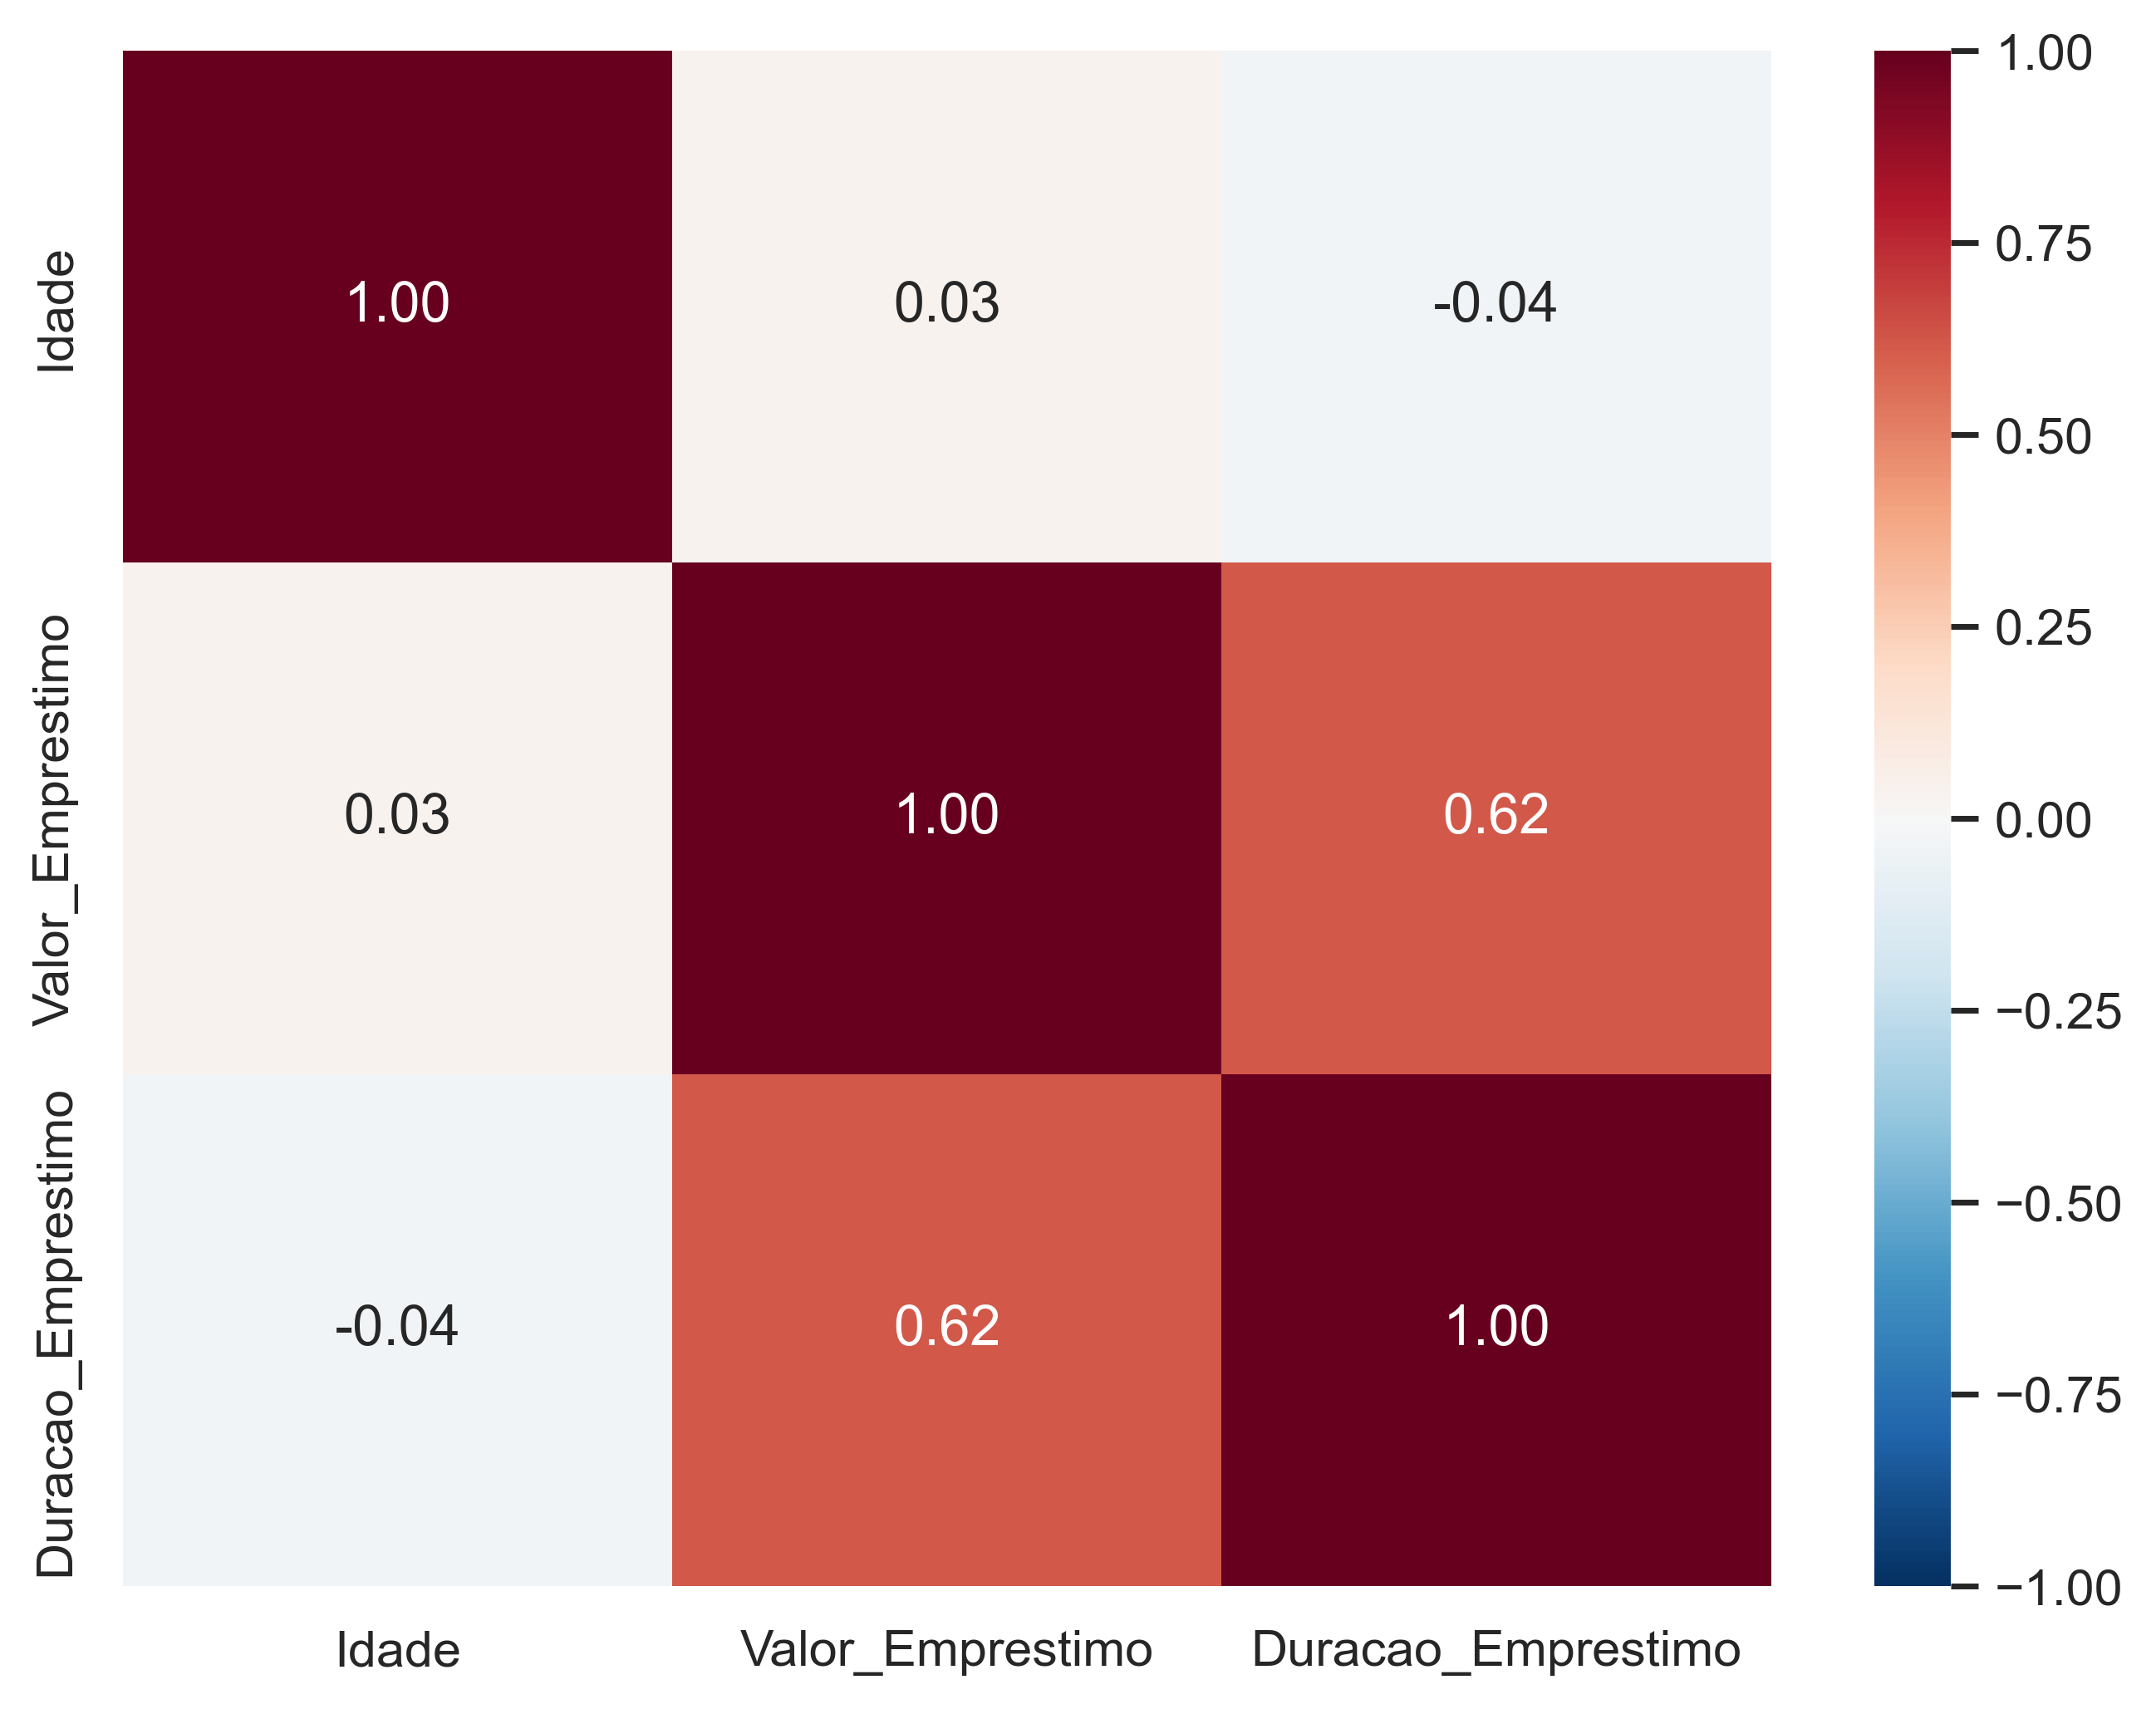

In [22]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(df[num_vars].corr(),
            fmt=".2f",
           cmap='RdBu_r',
           vmin=-1, vmax=1,
           annot=True);

#### 2.2.1.3 Análise IV - WOE (cat_vars)

In [23]:
df_iv = af.AnaliseIV(df[cat_vars + [target]], target=target, convention="good_over_bad")
df_iv.get_lista_iv()

Variavel     IV                               Forca_Preditiva
0  Saldo_Conta_Corrente  0.729  Muito forte (verificar possível overfitting)
1    Saldo_Investimento  0.192                                         Média
2          Tipo_Moradia  0.083                                         Fraca
3                  Sexo  0.027                                         Fraca
4          Escolaridade  0.008                                   Irrelevante

In [24]:
df_iv.get_bivariada(var='Saldo_Conta_Corrente')

Inadimplencia  Var_Range  NonEvent  Event  Total  Dist_Event  Dist_NonEvent  \
0                   Alto        87     21    108    0.070000       0.124286   
1               Moderado       126     98    224    0.326667       0.180000   
2                  Pouco       139    135    274    0.450000       0.198571   
3              Sem conta       348     46    394    0.153333       0.497143   

Inadimplencia       WOE        IV              Variavel  
0              0.574088  0.031165  Saldo_Conta_Corrente  
1             -0.595983  0.087411  Saldo_Conta_Corrente  
2             -0.818099  0.205693  Saldo_Conta_Corrente  
3              1.176263  0.404410  Saldo_Conta_Corrente

In [25]:
df_iv.get_bivariada(var='Saldo_Investimento')

Inadimplencia         Var_Range  NonEvent  Event  Total  Dist_Event  \
0                          Alto        94     17    111    0.056667   
1                      Moderado        69     34    103    0.113333   
2                         Pouco       386    217    603    0.723333   
3              Sem investimento       151     32    183    0.106667   

Inadimplencia  Dist_NonEvent       WOE        IV            Variavel  
0                   0.134286  0.862784  0.066968  Saldo_Investimento  
1                   0.098571 -0.139552  0.002060  Saldo_Investimento  
2                   0.551429 -0.271358  0.046648  Saldo_Investimento  
3                   0.215714  0.704246  0.076796  Saldo_Investimento

#### 2.2.1.4 Teste F ANOVA (num_vars)

In [26]:
# Exemplo prático
resultado_anova = af.calcular_f_anova(df, num_vars, target)
display(resultado_anova)

feature  F_statistic       p_value
0  Duracao_Emprestimo    48.333790  6.488050e-12
1    Valor_Emprestimo    24.482366  8.797572e-07
2               Idade     8.356995  3.925339e-03

### 2.2.2 Boxplots (Target x Pred)

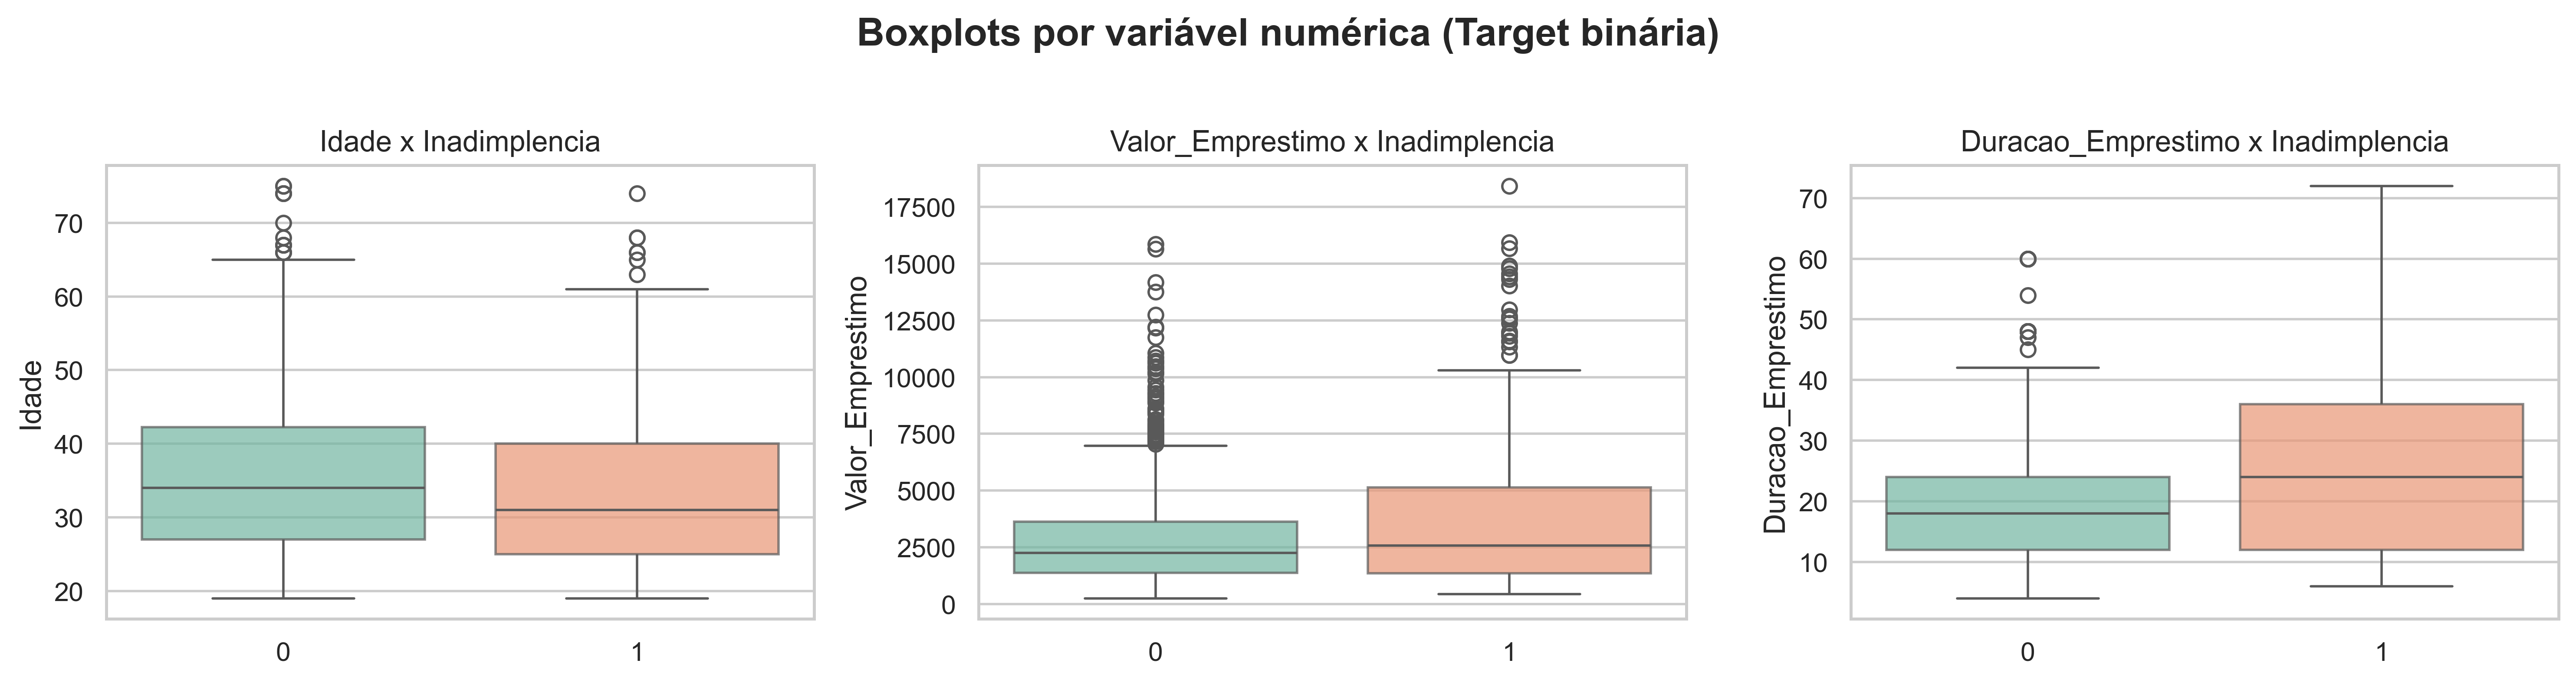

In [27]:
af.boxplots_target_binaria(df, target, num_vars)

In [28]:
def r2_categorico(df, cat_vars, target):
    """
    Calcula o coeficiente de determinação (R²) para variáveis categóricas
    com base na decomposição da variância (ANOVA univariada).

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame com as variáveis.
    cat_vars : list
        Lista de variáveis categóricas.
    target : str
        Nome da variável alvo contínua.

    Retorna
    -------
    pd.DataFrame
        Tabela com as variáveis categóricas e seus respectivos R² (variância explicada).
    """
    resultados = []
    y = df[target].dropna()
    var_total = np.var(y, ddof=1)  # variância total de Y

    for var in cat_vars:
        dados = df[[var, target]].dropna()
        grupos = dados.groupby(var)[target]

        # médias e tamanhos de cada grupo
        medias = grupos.mean()
        ns = grupos.size()

        # média geral
        media_geral = dados[target].mean()

        # soma dos quadrados entre grupos (SS_between)
        ss_between = np.sum(ns * (medias - media_geral)**2)

        # soma dos quadrados total
        ss_total = np.sum((dados[target] - media_geral)**2)

        # R² = SS_between / SS_total
        r2 = ss_between / ss_total if ss_total > 0 else np.nan
        resultados.append({"Variável": var, "R2_var": r2})

    resultados_df = pd.DataFrame(resultados).sort_values("R2_var", ascending=False).reset_index(drop=True)
    return resultados_df


In [29]:
r2_categorico(df,cat_vars,target)

Variável    R2_var
0  Saldo_Conta_Corrente  0.137350
1    Saldo_Investimento  0.035780
2          Tipo_Moradia  0.018200
3                  Sexo  0.005699
4          Escolaridade  0.001822

In [30]:
disc_vars, cont_vars = af.classificar_numericas(df, num_vars)

📊 Classificação das variáveis numéricas:
→ Discretas (1): ['Duracao_Emprestimo']
→ Contínuas (2): ['Idade', 'Valor_Emprestimo']


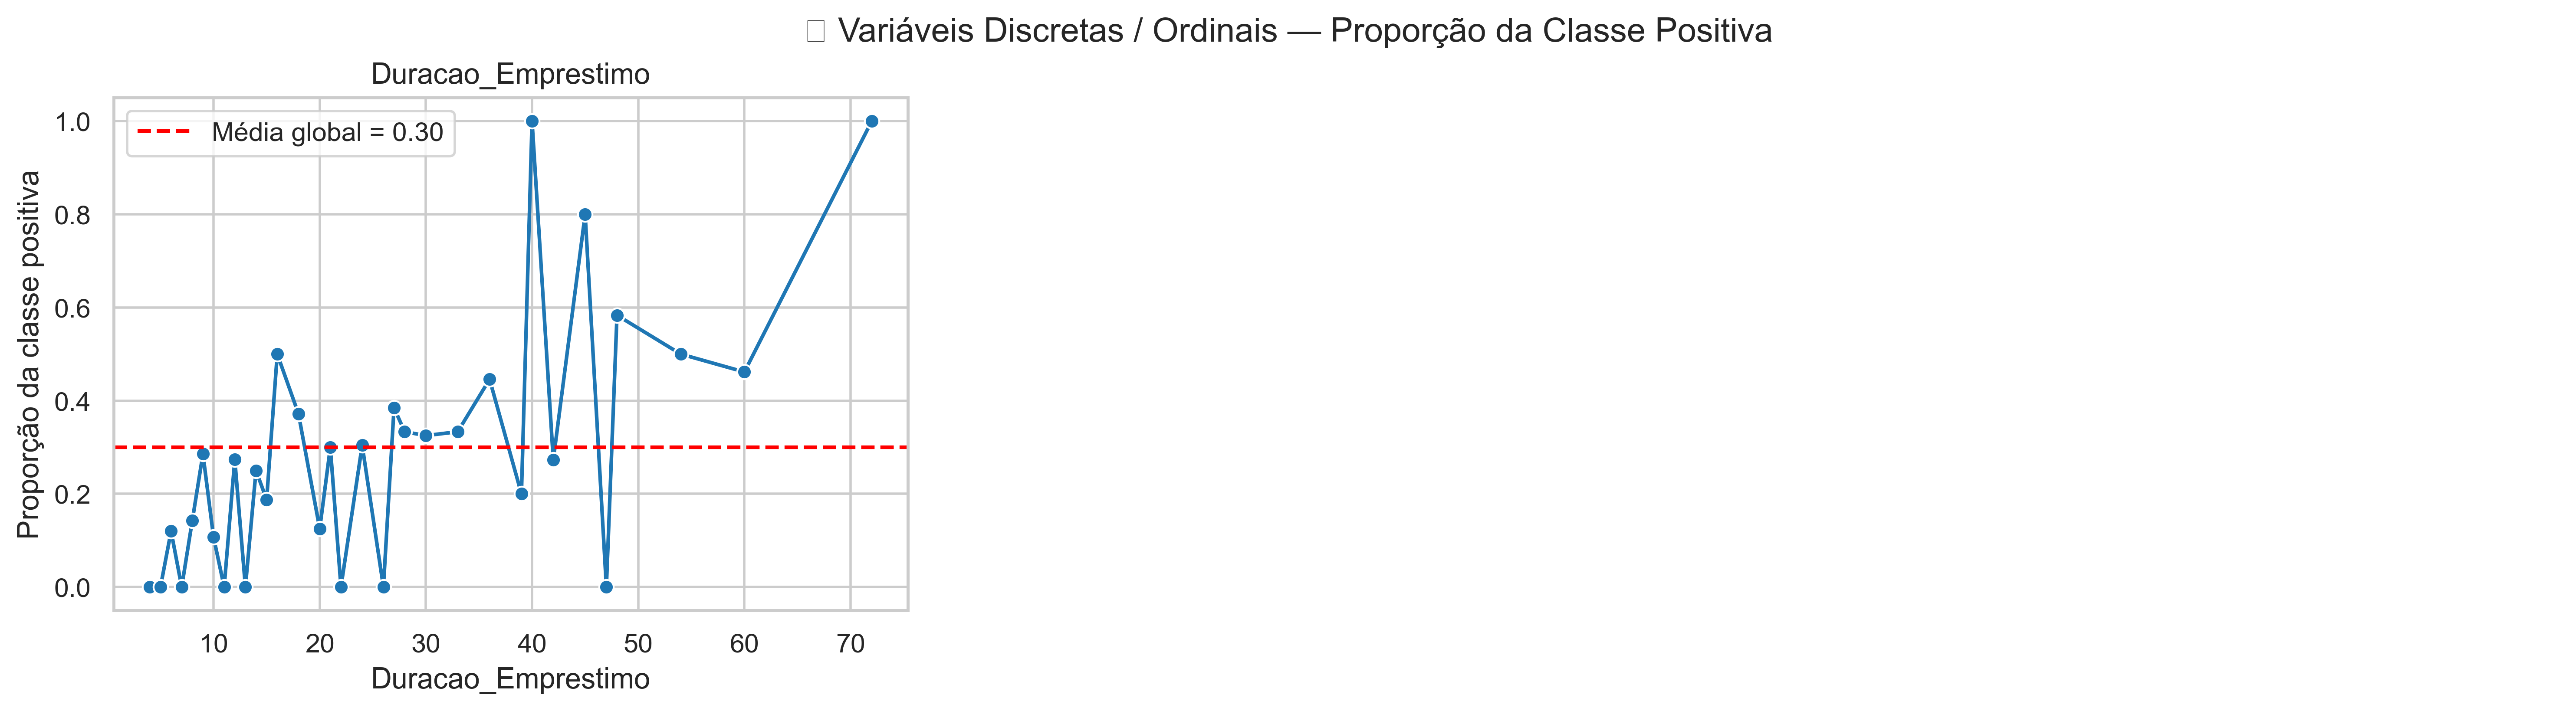

In [31]:
af.grid_disc_binario(df, target, disc_vars)

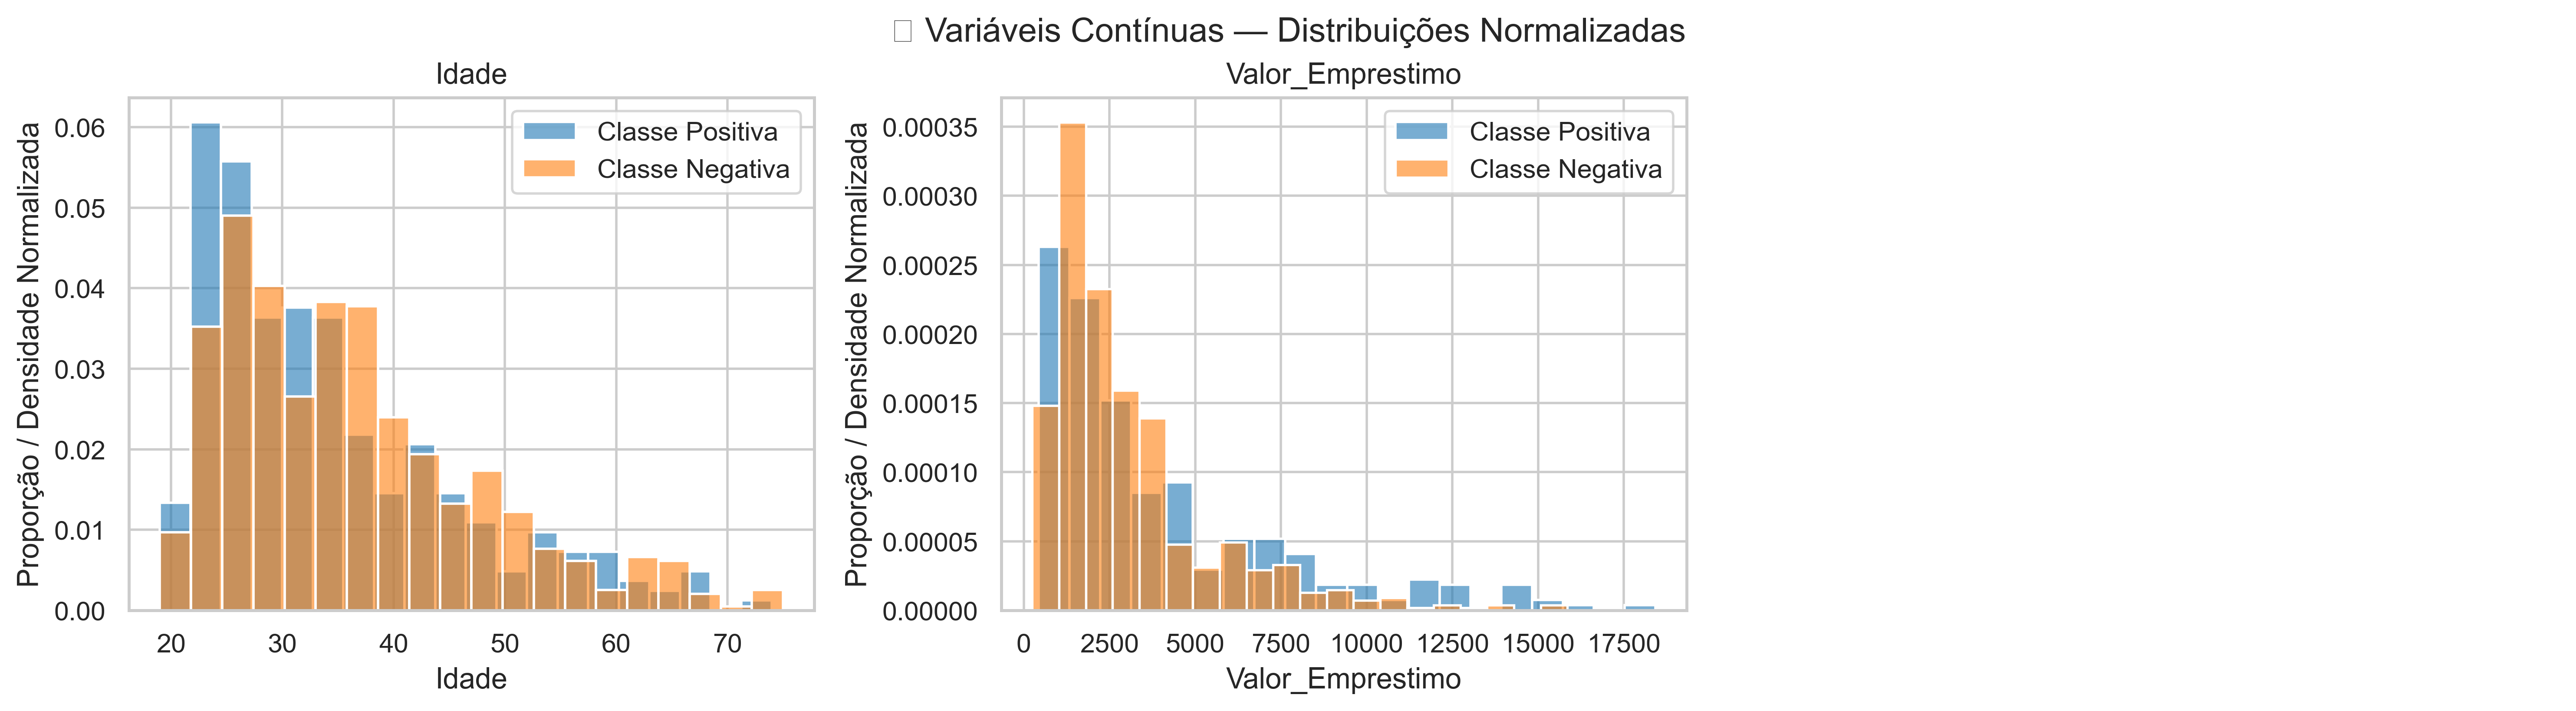

In [32]:
af.grid_cont_binario(df, target, cont_vars, bins=20)

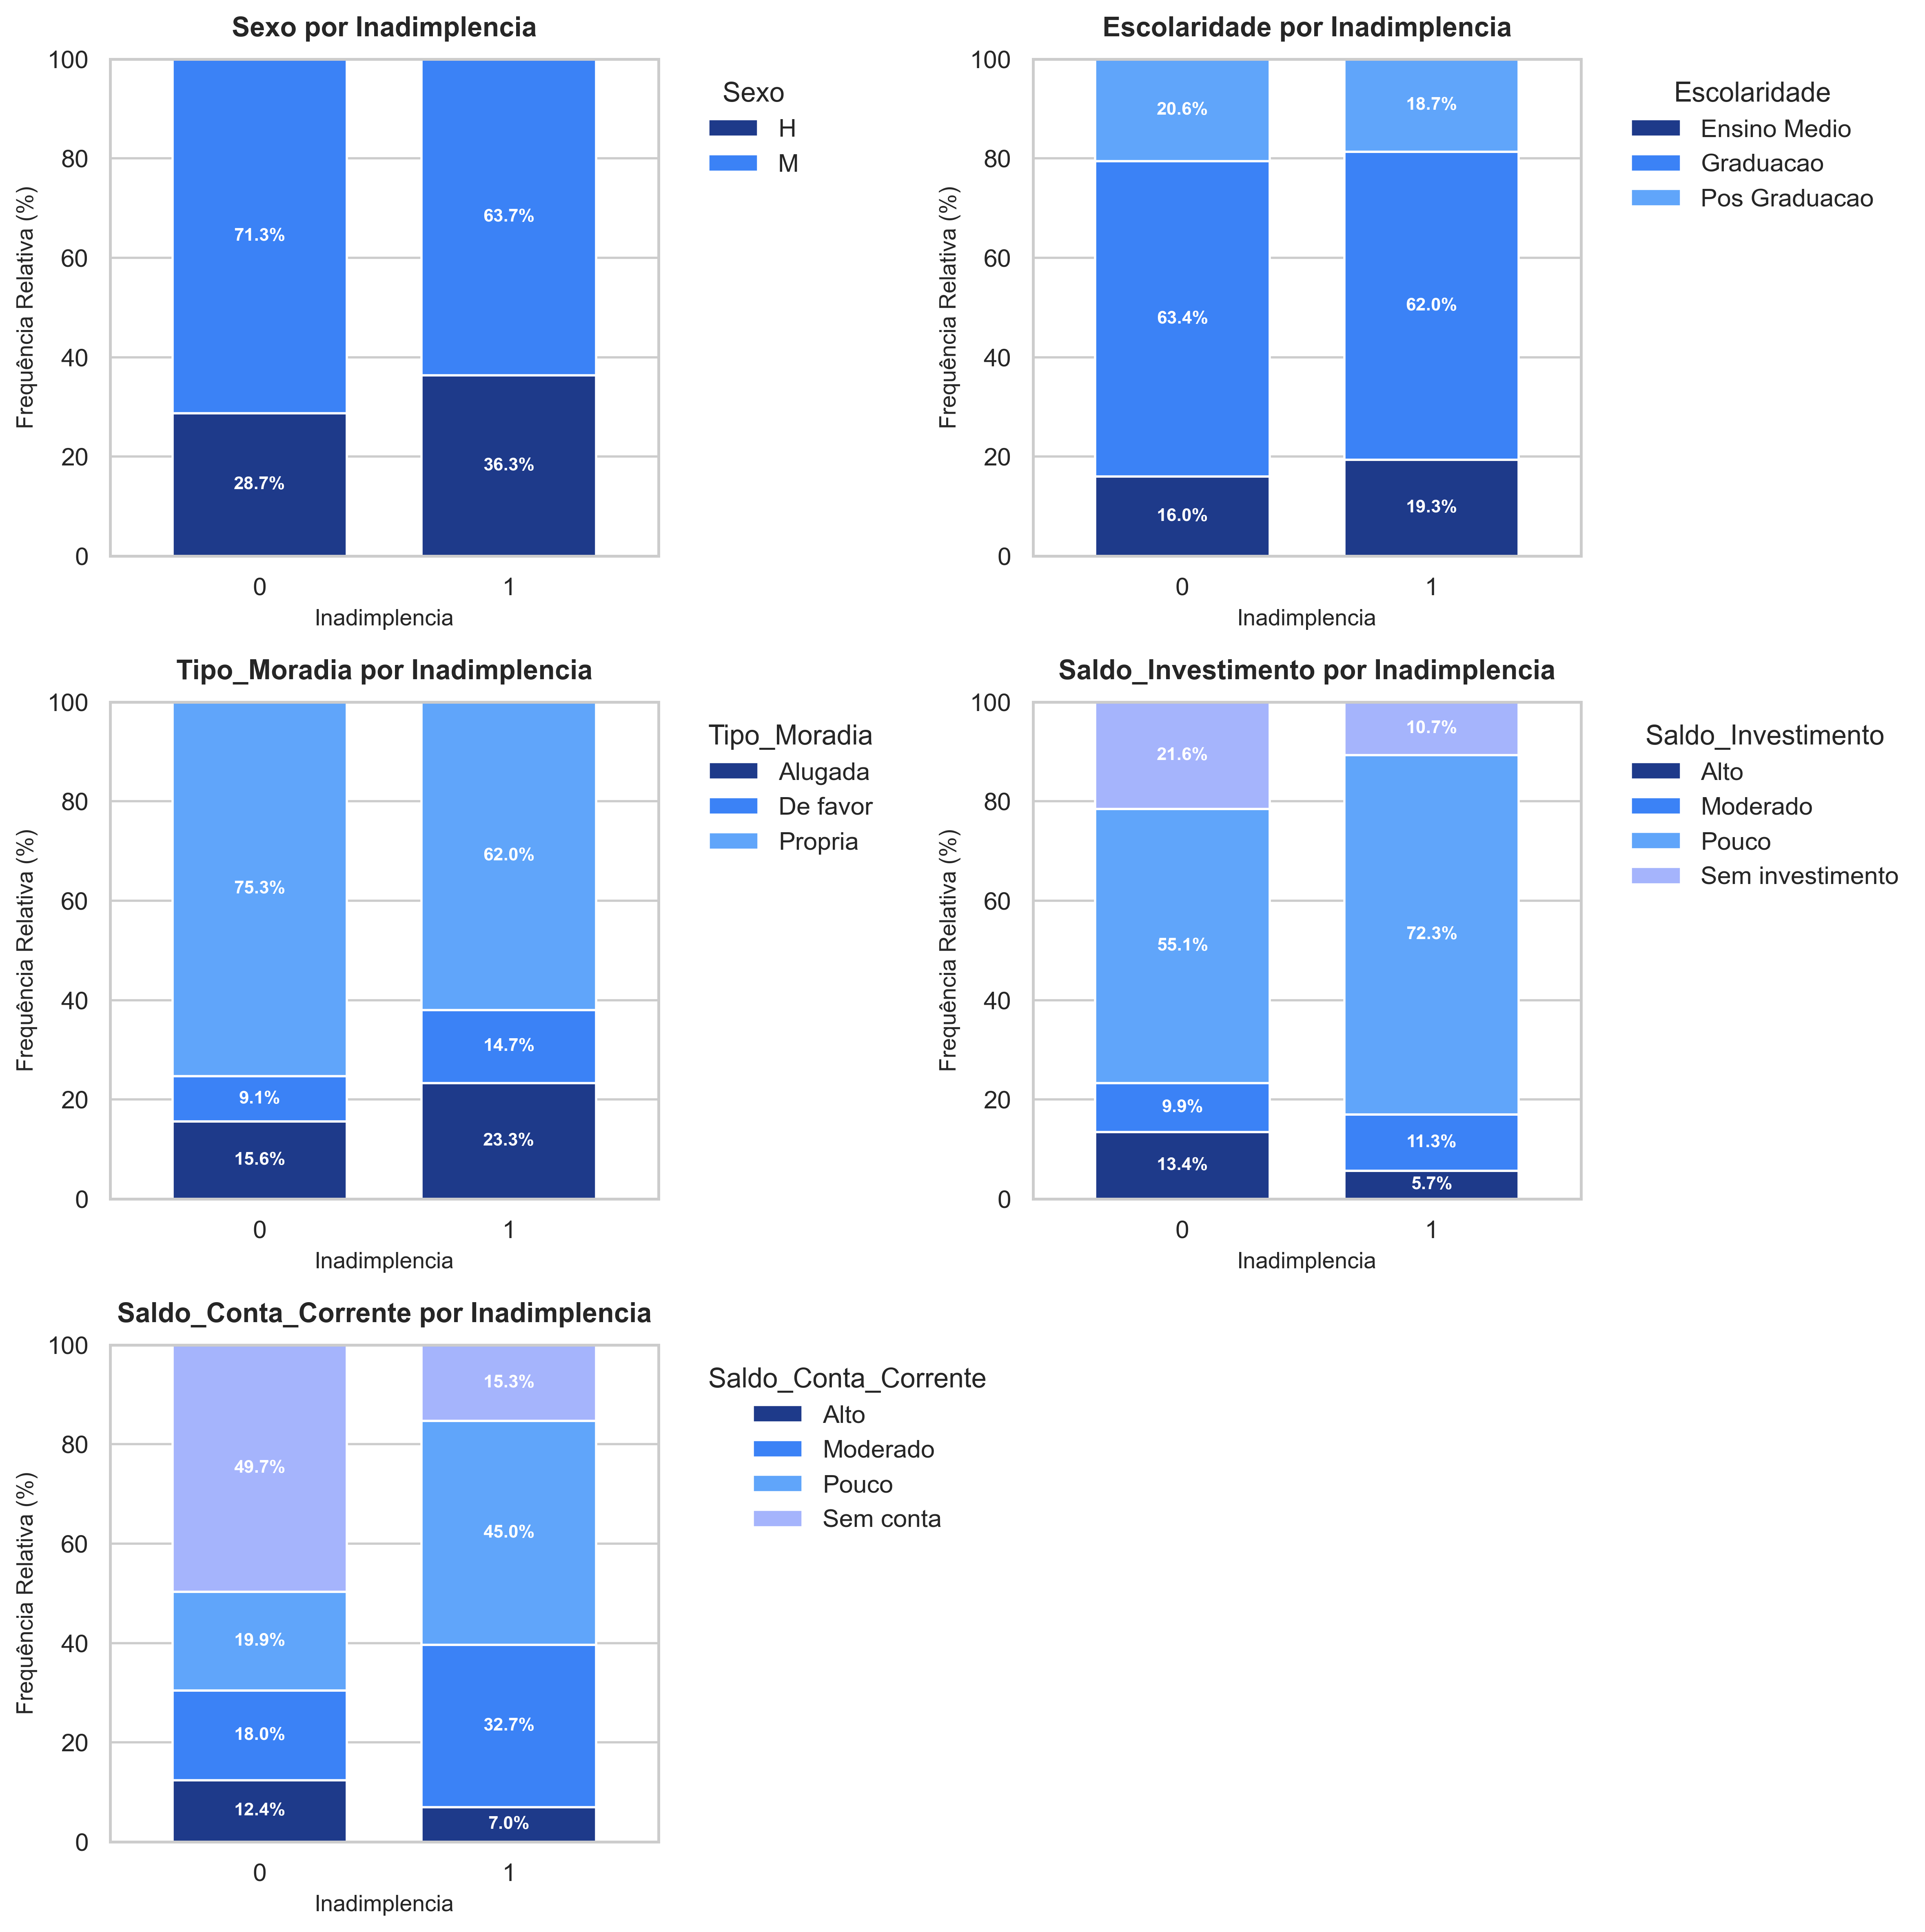

In [33]:
af.grid_stacked_bar(df, cat_vars, target, n_cols=2)

# 3. Preparação dos Dados

## 3.1 Codificando as Variáveis Categóricas

### checando a monotocidade entre as variáveis categóricas

In [34]:
for var in cat_vars:
    tabela = (
        df.groupby(var)
          .agg(
              Frequencia=(var, 'count'),
              Taxa_Alvo=(target, 'mean')
          )
          .assign(Taxa_Alvo=lambda x: (x['Taxa_Alvo'] * 100).round(2))
          .sort_values('Taxa_Alvo')
    )

    print(f"\n===== {var} =====")
    print(tabela)



===== Sexo =====
      Frequencia  Taxa_Alvo
Sexo                       
M            690      27.68
H            310      35.16

===== Escolaridade =====
               Frequencia  Taxa_Alvo
Escolaridade                        
Pos Graduacao         200      28.00
Graduacao             630      29.52
Ensino Medio          170      34.12

===== Tipo_Moradia =====
              Frequencia  Taxa_Alvo
Tipo_Moradia                       
Propria              713      26.09
Alugada              179      39.11
De favor             108      40.74

===== Saldo_Investimento =====
                    Frequencia  Taxa_Alvo
Saldo_Investimento                       
Alto                       111      15.32
Sem investimento           183      17.49
Moderado                   103      33.01
Pouco                      603      35.99

===== Saldo_Conta_Corrente =====
                      Frequencia  Taxa_Alvo
Saldo_Conta_Corrente                       
Sem conta                    394      11.68
Alt

### 3.1.1 Variáveis Dummy

In [35]:
dummy_vars = ['Sexo', 'Saldo_Investimento', 'Saldo_Conta_Corrente']

df_dummies = pd.get_dummies(df[dummy_vars], drop_first=True, dtype=int)
df_dummies

Sexo_M  Saldo_Investimento_Moderado  Saldo_Investimento_Pouco  \
0         1                            0                         0   
1         0                            0                         1   
2         1                            0                         1   
3         1                            0                         1   
4         1                            0                         1   
..      ...                          ...                       ...   
995       0                            0                         1   
996       1                            0                         1   
997       1                            0                         1   
998       1                            0                         1   
999       1                            1                         0   

     Saldo_Investimento_Sem investimento  Saldo_Conta_Corrente_Moderado  \
0                                      1                              0   
1                                      0                              1   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   
..                                   ...                            ...   
995                                    0                              0   
996                                    0                              0   
997                                    0                              0   
998                                    0                              0   
999                                    0                              1   

     Saldo_Conta_Corrente_Pouco  Saldo_Conta_Corrente_Sem conta  
0                             1                               0  
1                             0                               0  
2                             0                               1  
3                             1                               0  
4                             1                               0  
..                          ...                             ...  
995                           0                               1  
996                           1                               0  
997                           0                               1  
998                           1                               0  
999                           0                               0  

[1000 rows x 7 columns]

### 3.1.2 Mapeando as Variáveis Ordinais

In [36]:
ordinal_vars = ['Escolaridade', 'Tipo_Moradia']

In [37]:
# Dicionários de mapeamento conforme a ordem natural
map_escolaridade = {'Pos Graduacao':0, 'Graduacao':1, 'Ensino Medio':2}
map_tipo_moradia = {"Propria": 0, "Alugada": 1, "De favor": 2}

In [38]:
df_ordinals = df[ordinal_vars].copy()
df_ordinals['Escolaridade'] = df_ordinals['Escolaridade'].map(map_escolaridade)
df_ordinals['Tipo_Moradia'] = df_ordinals['Tipo_Moradia'].map(map_tipo_moradia)

In [39]:
df_ordinals

Escolaridade  Tipo_Moradia
0               1             0
1               1             0
2               0             0
3               1             2
4               1             2
..            ...           ...
995             0             0
996             2             0
997             1             0
998             1             2
999             1             0

[1000 rows x 2 columns]

### 3.1.3 df_final

In [40]:
df_final = pd.concat([df[num_vars], df_ordinals, df_dummies, df[target]], axis=1)
df_final

Idade  Valor_Emprestimo  Duracao_Emprestimo  Escolaridade  Tipo_Moradia  \
0       67              1169                   6             1             0   
1       22              5951                  48             1             0   
2       49              2096                  12             0             0   
3       45              7882                  42             1             2   
4       53              4870                  24             1             2   
..     ...               ...                 ...           ...           ...   
995     31              1736                  12             0             0   
996     40              3857                  30             2             0   
997     38               804                  12             1             0   
998     23              1845                  45             1             2   
999     27              4576                  45             1             0   

     Sexo_M  Saldo_Investimento_Moderado  Saldo_Investimento_Pouco  \
0         1                            0                         0   
1         0                            0                         1   
2         1                            0                         1   
3         1                            0                         1   
4         1                            0                         1   
..      ...                          ...                       ...   
995       0                            0                         1   
996       1                            0                         1   
997       1                            0                         1   
998       1                            0                         1   
999       1                            1                         0   

     Saldo_Investimento_Sem investimento  Saldo_Conta_Corrente_Moderado  \
0                                      1                              0   
1                                      0                              1   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   
..                                   ...                            ...   
995                                    0                              0   
996                                    0                              0   
997                                    0                              0   
998                                    0                              0   
999                                    0                              1   

     Saldo_Conta_Corrente_Pouco  Saldo_Conta_Corrente_Sem conta  Inadimplencia  
0                             1                               0              0  
1                             0                               0              1  
2                             0                               1              0  
3                             1                               0              0  
4                             1                               0              1  
..                          ...                             ...            ...  
995                           0                               1              0  
996                           1                               0              0  
997                           0                               1              0  
998                           1                               0              1  
999                           0                               0              0  

[1000 rows x 13 columns]

## 3.2 Separando X e y

In [41]:
# features
X = df_final.drop(target, axis=1)

# target
y = df_final[target]

In [42]:
X.shape

(1000, 12)

In [43]:
y.shape

(1000,)

# 4. Análise Multivariada

## 4.1 Árvore Exploratória

Como interpretar / workflow sugerido (prático)

- Escolha MOE: ex.: 0.05 (5%) se você quer ±5pp de precisão para a proporção dentro de cada folha.

- Escolha L_expected: quantas folhas você espera investigar. Se não souber, use 10–20; isso controla Bonferroni (conservador).

- Calcule n_min: a função te retorna; configure min_samples_leaf com ele.

- Treine a árvore (não para prever, mas para descobrir segmentos interpretáveis).

- Extraia leaf_summary: terá regra, n_total, n_pos, pos_rate. Regras com n_total≈n_min são no limite; fique atento.

- Bootstrap (n_boot = 50–200): regra com freq alta (ex.: > 0.6) é relativamente estável; regras com freq baixa são possivelmente artefato de amostra.

- Filtre: mantenha regras estáveis e com n_pos suficiente (em desbalanceamento, monitore n_pos absoluto).

- Para relatório: para cada regra estável forneça proporção e IC (Wald ou bootstrap CI). Se quiser IC exato por leaf, use método bootstrap para gerar intervalos empíricos.

Observações importantes e dicas

- Bonferroni é conservador — se tiver muitas folhas esperadas use FDR ou prefira confiar no bootstrap para estabilidade em vez de uma correção α rígida.

- min_samples_leaf controla tamanho total da folha, não garante um número mínimo de positivos; calcule n_pos_min = ceil(n_min * p_est) se quiser forçar positiva mínima esperada.

- Para exploração, max_depth geralmente é bom limitar para melhorar interpretabilidade (ex.: 3–6).

- Se o dataset for muito grande, n_min pode ficar pequeno relativo ao total; se for pequeno, n_min pode forçar poucas folhas (ok para segurança estatística).

- Use visualizações: tabela de regras, barplots das frequências das regras pelo bootstrap, e perfis das variáveis por folha.

In [44]:
import numpy as np
import pandas as pd
import math
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.utils import resample
import scipy.stats as st


# 1) Função para calcular min_samples_leaf (MOE + Bonferroni)
def min_n_for_proportion(moe=0.05, alpha=0.05, p_est=None, L=1):
    """
    Calcula tamanho mínimo da folha para garantir
    MOE para proporção com ajuste Bonferroni.
    """
    alpha_adj = alpha / L if L > 1 else alpha
    z = st.norm.ppf(1 - alpha_adj / 2)
    p = 0.5 if p_est is None else p_est
    n = (z**2 * p * (1 - p)) / (moe**2)
    return math.ceil(n)

# 2) Treina árvore exploratória
def train_exploratory_tree(X, y, moe=0.05, alpha=0.05, L_expected=10,
                           p_est=None, max_depth=None, random_state=42):

    n_min = min_n_for_proportion(moe=moe, alpha=alpha,
                                 p_est=p_est, L=L_expected)

    clf = DecisionTreeClassifier(
        min_samples_leaf=n_min,
        max_depth=max_depth,
        random_state=random_state
    )
    clf.fit(X, y)
    return clf, n_min

# 3) Estatísticas por folha
def leaf_stats(clf, X, y):
    leaf_ids = clf.apply(X)
    df = pd.DataFrame({'leaf_id': leaf_ids, 'y': np.asarray(y)})
    
    stats = (
        df.groupby('leaf_id')
          .agg(n_total=('y', 'size'),
               n_pos=('y', 'sum'),
               pos_rate=('y', 'mean'))
          .reset_index()
          .sort_values('n_total', ascending=False)
          .reset_index(drop=True)
    )
    return stats


# 4) Regras da árvore 
def _recurse_tree(tree: _tree.Tree, feature_names, node=0, conditions=None, rules=None):
    if conditions is None:
        conditions = []
    if rules is None:
        rules = {}

    # se é folha
    if tree.feature[node] == _tree.TREE_UNDEFINED:
        rules[node] = list(conditions)
        return rules

    feat = feature_names[tree.feature[node]]
    thresh = tree.threshold[node]

    # arredonda thresholds a 3 casas decimais
    thresh = round(float(thresh), 3)

    # esquerda: <= thresh
    conditions.append((feat, "<=", thresh))
    _recurse_tree(tree, feature_names, tree.children_left[node], conditions, rules)
    conditions.pop()

    # direita: > thresh
    conditions.append((feat, ">", thresh))
    _recurse_tree(tree, feature_names, tree.children_right[node], conditions, rules)
    conditions.pop()

    return rules


def extract_leaf_rules(clf, feature_names):
    tree = clf.tree_
    raw_rules = _recurse_tree(tree, feature_names)

    rules_text = {}

    for node_id, conds in raw_rules.items():

        # ordena as condições alfabeticamente pelo nome da variável
        conds_sorted = sorted(conds, key=lambda x: x[0])

        # monta texto da regra
        txt = " AND ".join([
            f"{feat} {op} {thr}" for (feat, op, thr) in conds_sorted
        ])

        rules_text[node_id] = txt if txt != "" else "ALL"

    return rules_text


# 5) Combinar regras + estatísticas
def leaf_summary(clf, X, y, feature_names):
    stats = leaf_stats(clf, X, y)
    rules = extract_leaf_rules(clf, feature_names)

    stats['rule'] = stats['leaf_id'].map(rules)

    return stats[['leaf_id', 'n_total', 'n_pos', 'pos_rate', 'rule']]


# 6) Bootstrap de estabilidade das regras
def bootstrap_rule_frequency(X, y, feature_names,
                             moe=0.05, alpha=0.05,
                             L_expected=10, p_est=None,
                             max_depth=None, n_boot=100,
                             random_state=42):

    rng = np.random.RandomState(random_state)
    rule_counts = {}

    for i in range(n_boot):
        # bootstrap sample
        Xb, yb = resample(X, y, replace=True,
                          random_state=rng.randint(0, 10**6))

        # garantir nomes
        if not isinstance(Xb, pd.DataFrame):
            Xb = pd.DataFrame(Xb, columns=feature_names)

        # treinar árvore bootstrap
        clf_b, nmin_b = train_exploratory_tree(
            Xb, yb, moe=moe, alpha=alpha,
            L_expected=L_expected, p_est=p_est,
            max_depth=max_depth,
            random_state=rng.randint(0, 10**6)
        )

        # extrair regras
        rules_b = extract_leaf_rules(clf_b, Xb.columns)

        # acumular contagem
        for rule_text in rules_b.values():
            rule_counts[rule_text] = rule_counts.get(rule_text, 0) + 1

    # montar dataframe final
    df = pd.DataFrame([
        {'rule': rule, 'count': cnt, 'freq': cnt / n_boot}
        for rule, cnt in rule_counts.items()
    ])

    # consolidar regras equivalentes (normalização simples)
    df['rule_norm'] = df['rule'].str.replace(r"\s+", " ", regex=True)

    df = (
        df.groupby('rule_norm')
          .agg(count=('count', 'sum'),
               freq=('freq', 'sum'),
               rule=('rule', 'first'))
          .sort_values('freq', ascending=False)
          .reset_index(drop=True)
    )

    return df[['rule', 'count', 'freq']]


### 7) Exemplo de uso (pseudo-fluxo)
# Suponha que você tenha:
# X -> pandas DataFrame com features
# y -> pandas Series ou array binário (0/1)
#
# feature_names = X.columns.tolist()
# clf, n_min = train_exploratory_tree(X, y, moe=0.05, alpha=0.05, L_expected=10, p_est=None)
# print("min_samples_leaf usado:", n_min)
# summary = leaf_summary(clf, X, y, feature_names)
# print(summary.head(50).to_string(index=False))
#
# # bootstrap para regras estáveis
# rule_freq = bootstrap_rule_frequency(X, y, feature_names, moe=0.05, alpha=0.05,
#                                      L_expected=10, p_est=None, n_boot=100)
# print(rule_freq.head(30))


In [45]:
dt_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)

dt_model.fit(X,y)

DecisionTreeClassifier(max_depth=3, random_state=42)

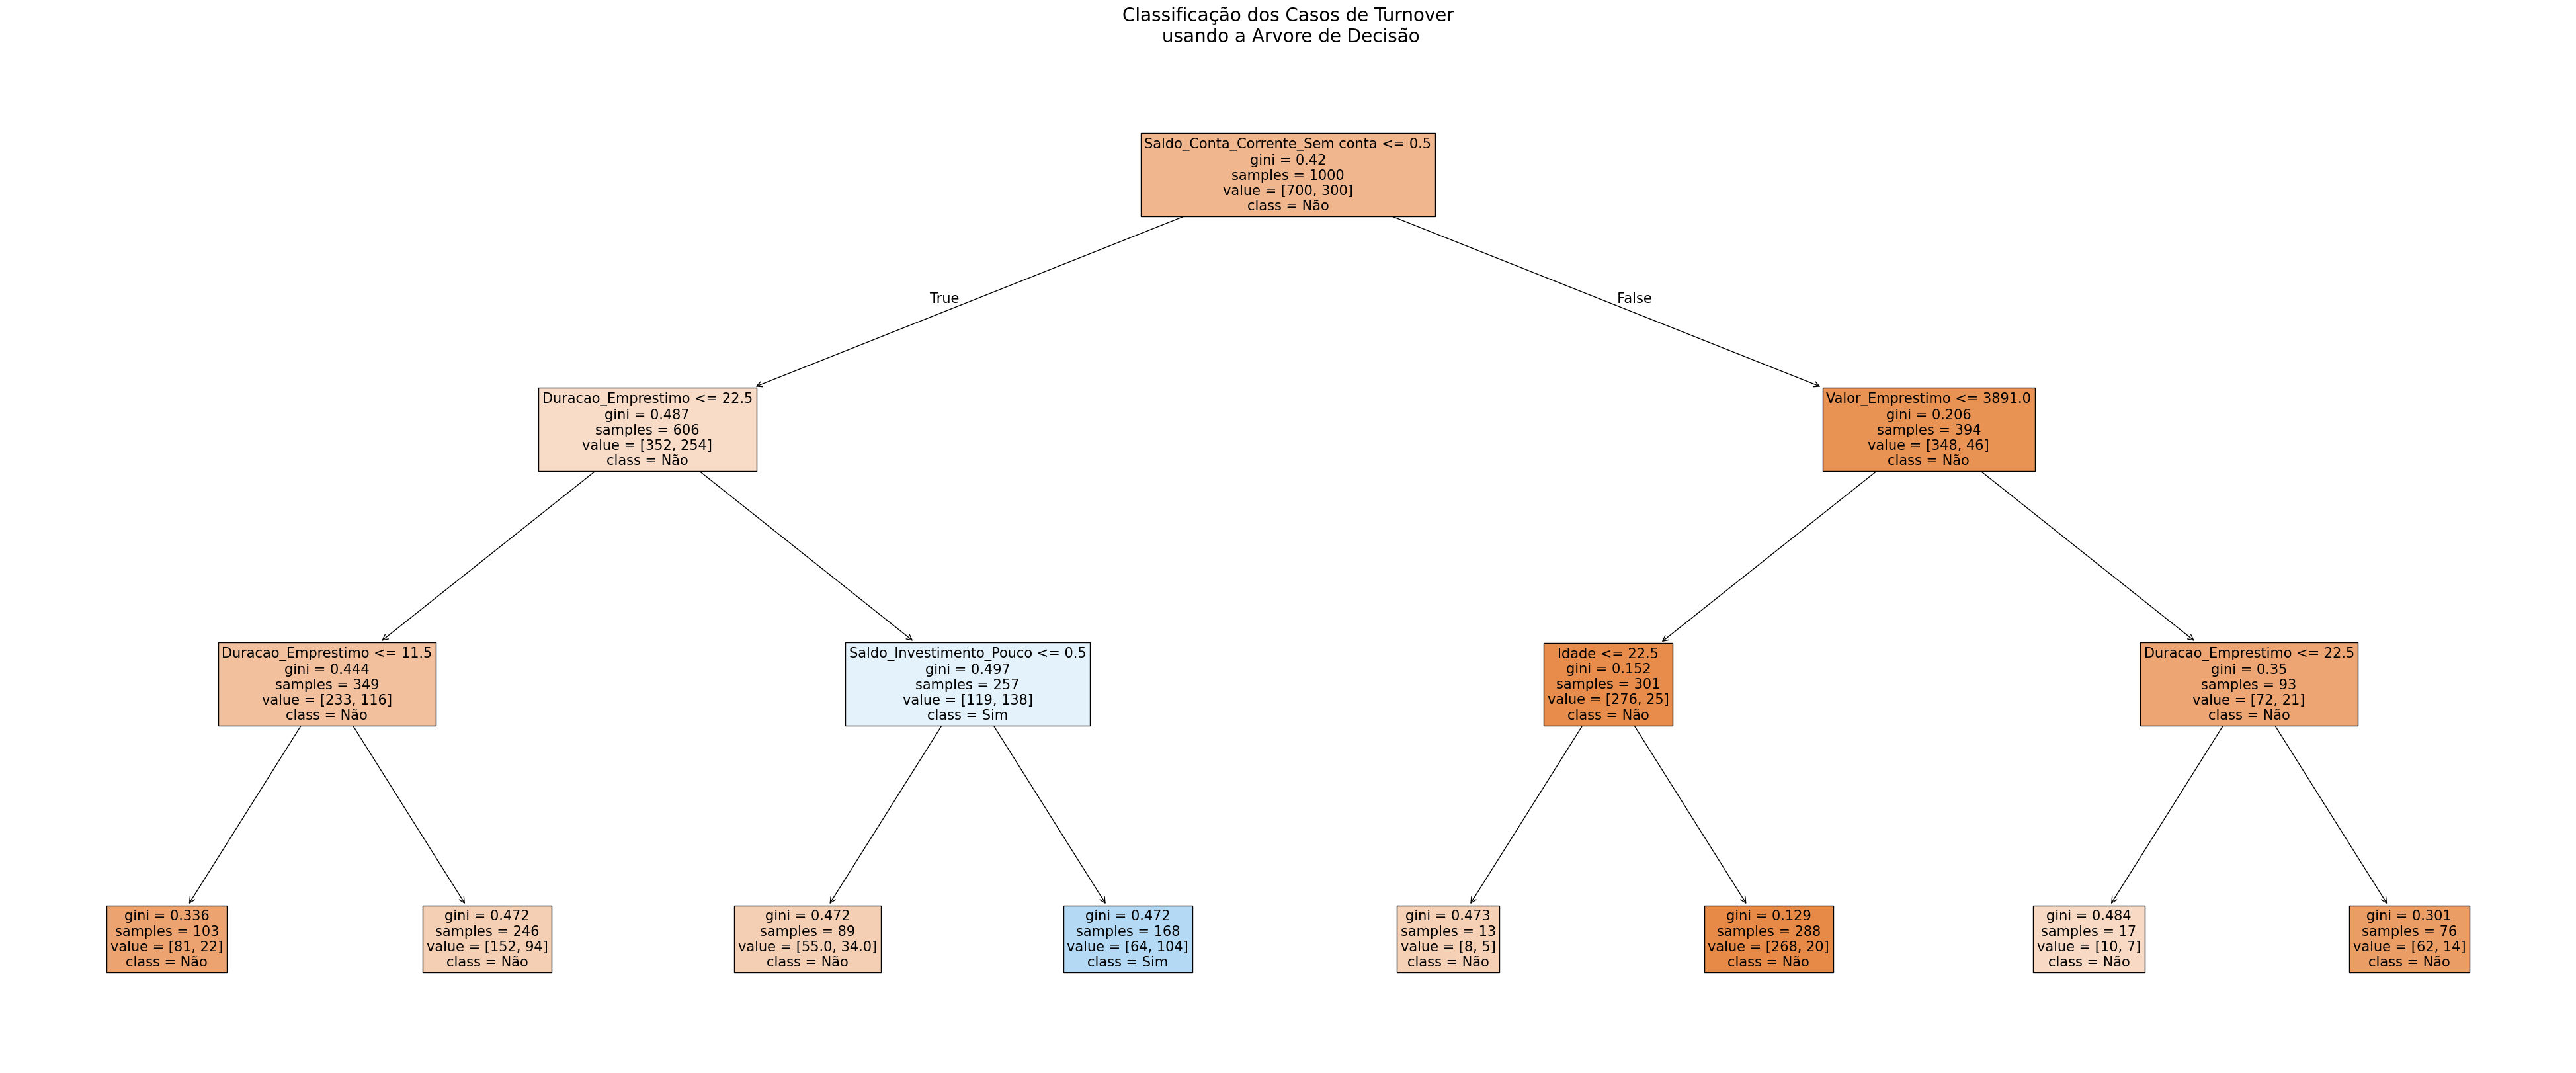

In [46]:
# visualizando a arvore
from sklearn import tree
sns.reset_defaults()
fig = plt.figure(figsize=(50, 20))
feature_names = X.columns.to_list()
tree.plot_tree(dt_model, feature_names=feature_names, filled=True, class_names=['Não', 'Sim'], fontsize=15);

plt.title('Classificação dos Casos de Turnover\n usando a Arvore de Decisão', fontsize=20)
plt.show()

In [47]:
summary = leaf_summary(dt_model, X, y, feature_names)
print(summary.head(50).to_string(index=False))

 leaf_id  n_total  n_pos  pos_rate                                                                                                    rule
      11      288     20  0.069444                    Idade > 22.5 AND Saldo_Conta_Corrente_Sem conta > 0.5 AND Valor_Emprestimo <= 3891.0
       4      246     94  0.382114      Duracao_Emprestimo <= 22.5 AND Duracao_Emprestimo > 11.5 AND Saldo_Conta_Corrente_Sem conta <= 0.5
       7      168    104  0.619048  Duracao_Emprestimo > 22.5 AND Saldo_Conta_Corrente_Sem conta <= 0.5 AND Saldo_Investimento_Pouco > 0.5
       3      103     22  0.213592     Duracao_Emprestimo <= 22.5 AND Duracao_Emprestimo <= 11.5 AND Saldo_Conta_Corrente_Sem conta <= 0.5
       6       89     34  0.382022 Duracao_Emprestimo > 22.5 AND Saldo_Conta_Corrente_Sem conta <= 0.5 AND Saldo_Investimento_Pouco <= 0.5
      14       76     14  0.184211        Duracao_Emprestimo > 22.5 AND Saldo_Conta_Corrente_Sem conta > 0.5 AND Valor_Emprestimo > 3891.0
      13       17      7  0

In [48]:
importances = dt_model.feature_importances_
features = X.columns

df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
})
df_imp.sort_values("importance", ascending=False).reset_index(drop=True)
df_imp

feature  importance
0                                 Idade    0.033611
1                      Valor_Emprestimo    0.039384
2                    Duracao_Emprestimo    0.244180
3                          Escolaridade    0.000000
4                          Tipo_Moradia    0.000000
5                                Sexo_M    0.000000
6           Saldo_Investimento_Moderado    0.000000
7              Saldo_Investimento_Pouco    0.088914
8   Saldo_Investimento_Sem investimento    0.000000
9         Saldo_Conta_Corrente_Moderado    0.000000
10           Saldo_Conta_Corrente_Pouco    0.000000
11       Saldo_Conta_Corrente_Sem conta    0.593911

In [49]:
import pandas as pd
import numpy as np

# --- 1) Garantias básicas e prints de debug (remova prints depois) ---
print("dtype do importances:", type(dt_model.feature_importances_))
print("shape importances:", np.shape(dt_model.feature_importances_))
print("n features em X:", len(X.columns))

# Se houver mismatch de tamanho, não segue em frente
if len(X.columns) != len(dt_model.feature_importances_):
    raise ValueError("Número de features em X.columns é diferente do tamanho de feature_importances_. "
                     f"{len(X.columns)} vs {len(dt_model.feature_importances_)}")

# --- 2) Monta DataFrame de forma robusta ---
importances = np.asarray(dt_model.feature_importances_).ravel()  # garante numpy 1D
features = list(X.columns)

df_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
})

# --- 3) Força tipo numérico e mostra problemas se existirem ---
df_imp["importance"] = pd.to_numeric(df_imp["importance"], errors="coerce")
n_nulls = df_imp["importance"].isna().sum()
if n_nulls > 0:
    print(f"Atenção: {n_nulls} importances viraram NaN ao converter para numérico. Confira o modelo/importances.")

# --- 4) Ordena explicitamente por numeric descending ---
df_imp = df_imp.sort_values(by="importance", ascending=False, kind="quicksort").reset_index(drop=True)

# --- 5) Resultado final ---
print(df_imp.head(20))
df_imp


dtype do importances: <class 'numpy.ndarray'>
shape importances: (12,)
n features em X: 12
                                feature  importance
0        Saldo_Conta_Corrente_Sem conta    0.593911
1                    Duracao_Emprestimo    0.244180
2              Saldo_Investimento_Pouco    0.088914
3                      Valor_Emprestimo    0.039384
4                                 Idade    0.033611
5                          Escolaridade    0.000000
6                                Sexo_M    0.000000
7                          Tipo_Moradia    0.000000
8           Saldo_Investimento_Moderado    0.000000
9   Saldo_Investimento_Sem investimento    0.000000
10        Saldo_Conta_Corrente_Moderado    0.000000
11           Saldo_Conta_Corrente_Pouco    0.000000


feature  importance
0        Saldo_Conta_Corrente_Sem conta    0.593911
1                    Duracao_Emprestimo    0.244180
2              Saldo_Investimento_Pouco    0.088914
3                      Valor_Emprestimo    0.039384
4                                 Idade    0.033611
5                          Escolaridade    0.000000
6                                Sexo_M    0.000000
7                          Tipo_Moradia    0.000000
8           Saldo_Investimento_Moderado    0.000000
9   Saldo_Investimento_Sem investimento    0.000000
10        Saldo_Conta_Corrente_Moderado    0.000000
11           Saldo_Conta_Corrente_Pouco    0.000000

### Extraindo regras via Boostrap

In [50]:
# Parâmetros
moe = 0.15          # margem de erro por folha (5%)
alpha = 0.05        # nível de significância (95% CI)
L_expected = 10     # número esperado de folhas exploratórias (para Bonferroni) — ajuste conforme seu plano
p_est = 0.3         # taxa global de Boa Performance

In [51]:
clf, n_min = train_exploratory_tree(X, y, moe=moe, alpha=alpha, L_expected=L_expected, p_est=p_est)
print("min_samples_leaf sugerido:", n_min)

min_samples_leaf sugerido: 74


In [52]:
feature_names = X.columns.tolist()

# bootstrap para regras estáveis
rule_freq = bootstrap_rule_frequency(X, y, feature_names, moe=moe, alpha=alpha,
                                      L_expected=L_expected, p_est=p_est, n_boot=200)                                    
rule_freq.head()

rule  count   freq
0  Saldo_Conta_Corrente_Sem conta > 0.5 AND Valor...     34  0.170
1  Duracao_Emprestimo <= 11.5 AND Saldo_Conta_Cor...     30  0.150
2  Duracao_Emprestimo > 22.5 AND Saldo_Conta_Corr...     29  0.145
3  Duracao_Emprestimo > 31.5 AND Saldo_Conta_Corr...     23  0.115
4  Saldo_Conta_Corrente_Sem conta > 0.5 AND Valor...     19  0.095

## 4.3 Modelagem Inferencial (logit)

### 4.3.1 Ajustando o Modelo

In [53]:
# Adicionando a Constante (intercepto)
X =  sm.add_constant(X)

# Criar modelo e Ajustar
clf_lr = sm.Logit(y, X)
result_lr = clf_lr.fit()

# Ver o Resumo
result_lr.summary()

Optimization terminated successfully.
         Current function value: 0.506414
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.1710
Time:                        15:10:31   Log-Likelihood:                -506.41
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 4.724e-38
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -2.0000      0.488     -4.095      0.000      -2.957      -1.043
Idade                                  -0.0141      0.007     -1.962      0.050      -0.028   -1.55e-05
Valor_Emprestimo                      2.97e-05   3.46e-05      0.859      0.390   -3.81e-05    9.75e-05
Duracao_Emprestimo                      0.0341      0.008      4.233      0.000       0.018       0.050
Escolaridade                            0.0114      0.133      0.085      0.932      -0.250       0.272
Tipo_Moradia                            0.2271      0.115      1.976      0.048       0.002       0.452
Sexo_M                                 -0.3962      0.168     -2.365      0.018      -0.725      -0.068
Saldo_Investimento_Moderado             0.5549      0.370      1.499      0.134      -0.171       1.280
Saldo_Investimento_Pouco                0.6893      0.300      2.294      0.022       0.100       1.278
Saldo_Investimento_Sem investimento     0.1804      0.368      0.490      0.624      -0.542       0.902
Saldo_Conta_Corrente_Moderado           0.9215      0.314      2.935      0.003       0.306       1.537
Saldo_Conta_Corrente_Pouco              1.1949      0.296      4.037      0.000       0.615       1.775
Saldo_Conta_Corrente_Sem conta         -0.6522      0.306     -2.135      0.033      -1.251      -0.053
=======================================================================================================
"""

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def logit_backward_LRT(
    X, y, sl=0.05, add_const=True, verbose=True, max_iter=100
):
    """
    Eliminação recursiva (backward) de variáveis em Logit, usando:
    - p-values para indicar a variável candidata à remoção
    - LRT (Likelihood Ratio Test) para confirmar a exclusão
    - logging detalhado de cada iteração
    
    Retorna:
      model_final : modelo final ajustado (statsmodels)
      selected_vars : lista final de variáveis (inclui const se add_const=True)
      history_df : DataFrame com histórico detalhado (p-values, AIC, LLF, OR, LRT, etc.)
    """
    X_work = X.copy()
    if add_const:
        X_work = sm.add_constant(X_work, has_constant='add')
    variables = X_work.columns.tolist()
    
    history = []
    iteration = 0
    prev_aic, prev_llf = np.nan, np.nan
    
    while iteration < max_iter:
        iteration += 1
        try:
            model_full = sm.Logit(y, X_work[variables]).fit(disp=False)
        except PerfectSeparationError:
            if verbose:
                print(f"⚠️ Parou: separação perfeita com {variables}")
            break
        except Exception as e:
            if verbose:
                print(f"⚠️ Erro ao ajustar o modelo: {e}")
            break

        pvals = model_full.pvalues.copy()
        pvals_no_const = pvals.drop(labels=[c for c in ['const'] if c in pvals], errors='ignore')
        max_pval = pvals_no_const.max() if not pvals_no_const.empty else 0.0
        worst_var = pvals_no_const.idxmax() if not pvals_no_const.empty else None

        # Calcular VIFs (se possível)
        vif_dict = {}
        if len(variables) > 2:  # evitar erro com 1 variável + const
            try:
                vif_data = pd.DataFrame()
                vif_data["variable"] = [v for v in variables if v != 'const']
                vif_data["VIF"] = [
                    variance_inflation_factor(X_work[variables].values, i+1)
                    for i in range(len(vif_data))
                ]
                vif_dict = dict(zip(vif_data["variable"], vif_data["VIF"]))
            except Exception:
                pass
        
        # Registrar métricas básicas
        hist_row = {
            "iteration": iteration,
            "vars": variables.copy(),
            "aic": model_full.aic,
            "llf": model_full.llf,
            "delta_aic": model_full.aic - prev_aic if not np.isnan(prev_aic) else np.nan,
            "delta_llf": model_full.llf - prev_llf if not np.isnan(prev_llf) else np.nan,
            "max_pval": max_pval,
            "worst_var": worst_var,
            "removed": None,
            "lrt_pvalue": np.nan
        }
        
        # p-values, coef, OR e VIFs
        for v in variables:
            hist_row[f"p_{v}"] = pvals.get(v, np.nan)
            hist_row[f"coef_{v}"] = model_full.params.get(v, np.nan)
            hist_row[f"OR_{v}"] = np.exp(model_full.params.get(v, np.nan))
            hist_row[f"VIF_{v}"] = vif_dict.get(v, np.nan)
        
        # critério de parada
        if worst_var is None or max_pval <= sl:
            if verbose:
                print(f"✅ Iter {iteration}: todos p <= {sl:.2f}. Parando.")
            history.append(hist_row)
            break
        
        # Teste de razão de verossimilhança (LRT)
        vars_reduced = [v for v in variables if v != worst_var]
        try:
            model_reduced = sm.Logit(y, X_work[vars_reduced]).fit(disp=False)
            lr_stat = 2 * (model_full.llf - model_reduced.llf)
            lr_pvalue = stats.chi2.sf(lr_stat, df=1)
            hist_row["lrt_pvalue"] = lr_pvalue
        except Exception:
            if verbose:
                print(f"⚠️ Não foi possível ajustar modelo reduzido sem {worst_var}.")
            lr_pvalue = np.nan
        
        if verbose:
            print(f"Iter {iteration}: pior variável '{worst_var}' (p={max_pval:.4f}) | LRT p={lr_pvalue:.4f}")
        
        # Se o LRT não é significativo, remove a variável
        if not np.isnan(lr_pvalue) and lr_pvalue > sl:
            variables.remove(worst_var)
            hist_row["removed"] = worst_var
            if verbose:
                print(f"   ➖ Removendo '{worst_var}' (p={max_pval:.4f}, LRT p={lr_pvalue:.4f})")
        else:
            if verbose:
                print(f"   🚫 Mantendo '{worst_var}' (p={max_pval:.4f}, LRT p={lr_pvalue:.4f}) — influencia relevante.")
            history.append(hist_row)
            break
        
        # registrar histórico
        history.append(hist_row)
        prev_aic, prev_llf = model_full.aic, model_full.llf

        # condição extra de parada
        if len(variables) <= 1:
            if verbose:
                print("⚠️ Restou apenas constante, parando.")
            break
    
    # modelo final
    try:
        model_final = sm.Logit(y, X_work[variables]).fit(disp=False)
    except Exception:
        model_final = model_full
    
    history_df = pd.DataFrame(history)
    return model_final, variables, history_df

In [55]:
clf_rl_final, vars_final, hist = logit_backward_LRT(X, y, sl=0.05, verbose=True, add_const=False)

print("\n Variáveis Finais:", vars_final)

Iter 1: pior variável 'Escolaridade' (p=0.9319) | LRT p=0.9319
   ➖ Removendo 'Escolaridade' (p=0.9319, LRT p=0.9319)
Iter 2: pior variável 'Saldo_Investimento_Sem investimento' (p=0.6254) | LRT p=0.6240
   ➖ Removendo 'Saldo_Investimento_Sem investimento' (p=0.6254, LRT p=0.6240)
Iter 3: pior variável 'Valor_Emprestimo' (p=0.3473) | LRT p=0.3478
   ➖ Removendo 'Valor_Emprestimo' (p=0.3473, LRT p=0.3478)
Iter 4: pior variável 'Saldo_Investimento_Moderado' (p=0.1474) | LRT p=0.1498
   ➖ Removendo 'Saldo_Investimento_Moderado' (p=0.1474, LRT p=0.1498)
✅ Iter 5: todos p <= 0.05. Parando.

 Variáveis Finais: ['const', 'Idade', 'Duracao_Emprestimo', 'Tipo_Moradia', 'Sexo_M', 'Saldo_Investimento_Pouco', 'Saldo_Conta_Corrente_Moderado', 'Saldo_Conta_Corrente_Pouco', 'Saldo_Conta_Corrente_Sem conta']


In [56]:
clf_rl_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            8
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.1684
Time:                        15:10:31   Log-Likelihood:                -508.02
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 4.023e-40
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.7832      0.392     -4.550      0.000      -2.551      -1.015
Idade                             -0.0144      0.007     -2.022      0.043      -0.028      -0.000
Duracao_Emprestimo                 0.0389      0.006      6.099      0.000       0.026       0.051
Tipo_Moradia                       0.2435      0.113      2.157      0.031       0.022       0.465
Sexo_M                            -0.3807      0.167     -2.281      0.023      -0.708      -0.054
Saldo_Investimento_Pouco           0.4266      0.172      2.484      0.013       0.090       0.763
Saldo_Conta_Corrente_Moderado      1.0084      0.291      3.461      0.001       0.437       1.580
Saldo_Conta_Corrente_Pouco         1.2243      0.288      4.250      0.000       0.660       1.789
Saldo_Conta_Corrente_Sem conta    -0.6278      0.298     -2.104      0.035      -1.213      -0.043
==================================================================================================
"""

In [57]:
#hist.head(5)

In [58]:
vars_final

['const',
 'Idade',
 'Duracao_Emprestimo',
 'Tipo_Moradia',
 'Sexo_M',
 'Saldo_Investimento_Pouco',
 'Saldo_Conta_Corrente_Moderado',
 'Saldo_Conta_Corrente_Pouco',
 'Saldo_Conta_Corrente_Sem conta']

In [59]:
clf_rl_final.params

const                            -1.783165
Idade                            -0.014421
Duracao_Emprestimo                0.038947
Tipo_Moradia                      0.243483
Sexo_M                           -0.380694
Saldo_Investimento_Pouco          0.426563
Saldo_Conta_Corrente_Moderado     1.008440
Saldo_Conta_Corrente_Pouco        1.224319
Saldo_Conta_Corrente_Sem conta   -0.627761
dtype: float64

### 4.3.3 Interpretação dos Coeficientes (ODDs)

In [60]:
def get_odds_ratios(clf_final):
    """
    Calcula coeficientes, Odds Ratio (OR) e intervalos de confiança (IC 95%) 
    tanto em log-odds quanto em percentuais, para um modelo Logit do statsmodels.

    Parâmetros
    ----------
    clf_final : statsmodels.discrete.discrete_model.BinaryResultsWrapper
        Modelo Logit ajustado.

    Retorna
    -------
    pd.DataFrame com:
        - Variável
        - Coeficiente (β)
        - IC_Inf_β, IC_Sup_β
        - OR (exp(β))
        - Aumento_% (variação em % das chances)
        - IC_Inf_%, IC_Sup_%
    """
    # Coeficientes e IC em log-odds
    coef = clf_final.params
    conf = clf_final.conf_int()
    conf.columns = ['IC_Inf_β', 'IC_Sup_β']
    
    # Cálculo do OR e ICs correspondentes
    OR = np.exp(coef)
    IC_inf_OR = np.exp(conf['IC_Inf_β'])
    IC_sup_OR = np.exp(conf['IC_Sup_β'])
    
    # Conversão para variação percentual (OR - 1)*100
    aumento_pct = (OR - 1) * 100
    IC_inf_pct = (IC_inf_OR - 1) * 100
    IC_sup_pct = (IC_sup_OR - 1) * 100
    
    # Construção do DataFrame
    df = pd.DataFrame({
        'Variável': coef.index,
        'Coeficiente (β)': coef.values,
        'IC_Inf_β': conf['IC_Inf_β'].values,
        'IC_Sup_β': conf['IC_Sup_β'].values,
        'OR': OR.values,
        '%': aumento_pct.values,
        'IC_Inf_%': IC_inf_pct.values,
        'IC_Sup_%': IC_sup_pct.values
    })
    
    # Ordenar pelo OR (maior impacto)
    df = df.sort_values(by='OR', ascending=False).reset_index(drop=True)
    
    # Formatar percentuais para legibilidade
    df['%'] = df['%'].round(2)
    df['IC_Inf_%'] = df['IC_Inf_%'].round(2)
    df['IC_Sup_%'] = df['IC_Sup_%'].round(2)
    
    return df


In [61]:
get_odds_ratios(clf_rl_final)

Variável  Coeficiente (β)  IC_Inf_β  IC_Sup_β  \
0      Saldo_Conta_Corrente_Pouco         1.224319  0.659703  1.788935   
1   Saldo_Conta_Corrente_Moderado         1.008440  0.437313  1.579568   
2        Saldo_Investimento_Pouco         0.426563  0.090013  0.763112   
3                    Tipo_Moradia         0.243483  0.022277  0.464689   
4              Duracao_Emprestimo         0.038947  0.026430  0.051464   
5                           Idade        -0.014421 -0.028402 -0.000439   
6                          Sexo_M        -0.380694 -0.707762 -0.053626   
7  Saldo_Conta_Corrente_Sem conta        -0.627761 -1.212653 -0.042870   
8                           const        -1.783165 -2.551201 -1.015130   

         OR       %  IC_Inf_%  IC_Sup_%  
0  3.401848  240.18     93.42    498.31  
1  2.741323  174.13     54.85    385.29  
2  1.531982   53.20      9.42    114.49  
3  1.275685   27.57      2.25     59.15  
4  1.039715    3.97      2.68      5.28  
5  0.985683   -1.43     -2.80     -0.04  
6  0.683387  -31.66    -50.73     -5.22  
7  0.533785  -46.62    -70.26     -4.20  
8  0.168105  -83.19    -92.20    -63.76

# 5. Avaliando a Possibilidade de um Modelo Preditivo de Machine Learning

## 5.1 Regressão Logística

In [62]:
# escalonamento
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
# instanciando o modelo
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=1000, random_state=42, fit_intercept=False)

# ajustanto o modelo
logit.fit(X_scaled, y)

LogisticRegression(fit_intercept=False, max_iter=1000, random_state=42)

In [64]:
# rodando uma validação cruzada KFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# AUC com CV (para avaliar generalização)
auc_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='roc_auc')
acc_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='precision')

print("Validação cruzada (10-folds):")
print(f"AUC médio:        {auc_scores.mean():.3f} (+/- {auc_scores.std():.3f})")
print(f"Acurácia média:   {acc_scores.mean():.3f} (+/- {acc_scores.std():.3f})")
print(f"F1-Score médio:   {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
print(f"Recall médio:     {recall_scores.mean():.3f} (+/- {recall_scores.std():.3f})")
print(f"Precisão média:   {precision_scores.mean():.3f} (+/- {precision_scores.std():.3f})")

Validação cruzada (10-folds):
AUC médio:        0.753 (+/- 0.044)
Acurácia média:   0.660 (+/- 0.042)
F1-Score médio:   0.583 (+/- 0.048)
Recall médio:     0.790 (+/- 0.068)
Precisão média:   0.462 (+/- 0.041)


## 5.2 Árvore de Decisão

In [65]:
# instanciando o modelo
clf_dt = DecisionTreeClassifier(random_state=42)

# treinando o modelo
clf_dt.fit(X, y)

DecisionTreeClassifier(random_state=42)

In [66]:
# rodando uma validação cruzada KFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# AUC com CV (para avaliar generalização)
auc_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='roc_auc')
acc_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='precision')

print("Validação cruzada (10-folds):")
print(f"AUC médio:        {auc_scores.mean():.3f} (+/- {auc_scores.std():.3f})")
print(f"Acurácia média:   {acc_scores.mean():.3f} (+/- {acc_scores.std():.3f})")
print(f"F1-Score médio:   {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
print(f"Recall médio:     {recall_scores.mean():.3f} (+/- {recall_scores.std():.3f})")
print(f"Precisão média:   {precision_scores.mean():.3f} (+/- {precision_scores.std():.3f})")

Validação cruzada (10-folds):
AUC médio:        0.620 (+/- 0.049)
Acurácia média:   0.682 (+/- 0.046)
F1-Score médio:   0.465 (+/- 0.071)
Recall médio:     0.463 (+/- 0.091)
Precisão média:   0.475 (+/- 0.076)
